In [1]:
from IPython.display import Image

### MNIST

 - MultilayerPerceptronClassification < Pipeline

### 기존에 저장된 성능 좋은 PipelineModel Loading

In [ ]:
import org.apache.spark.ml.{Pipeline,PipelineModel} 
val modelPath= "hdfs://hadoop-master-01:9000/kikang/data/MNIST_mlp2"
val loaded_pipeline_model = PipelineModel.load(s"$modelPath/pipeline-model")

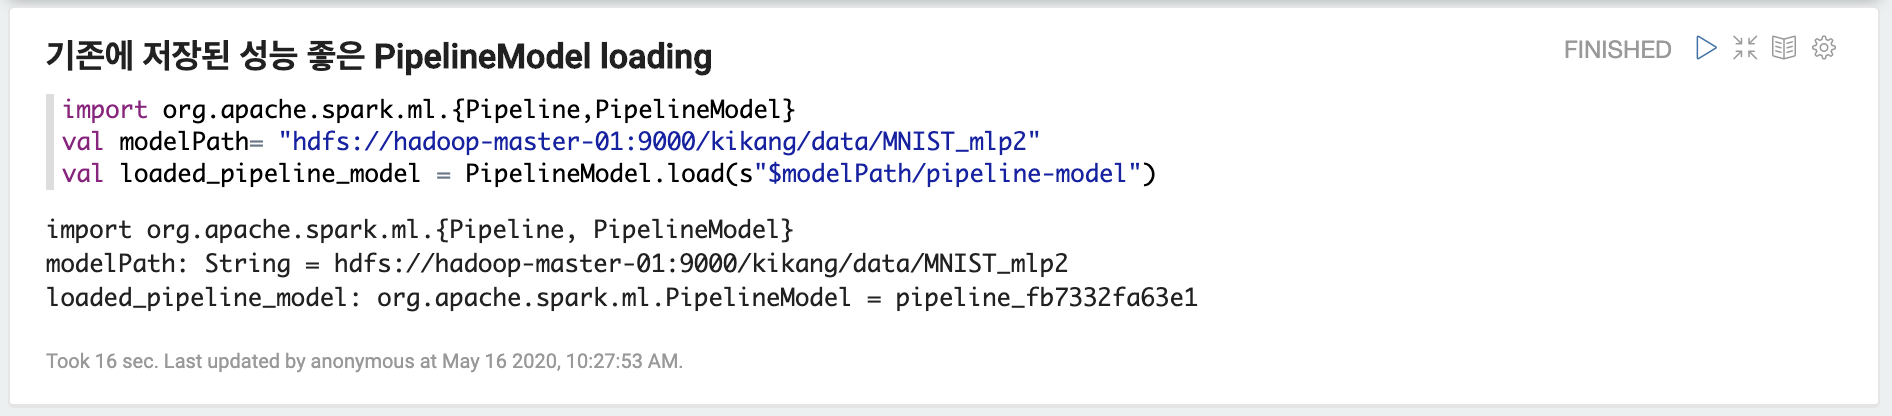

In [2]:
Image('./capture/01_mnist.png')

### 성능 좋은 PipelineModel로 test 예측 수행

In [ ]:
val train_raw = spark.read.csv("hdfs://hadoop-master-01:9000/kikang/data/MNIST/mnist_train.csv")
val test_raw = spark.read.csv("hdfs://hadoop-master-01:9000/kikang/data/MNIST/mnist_test.csv")
val toIntUDF = spark.udf.register("to_int", (arg1: String) => arg1.toInt)

In [ ]:
train_raw.createOrReplaceTempView("train_raw")
test_raw.createOrReplaceTempView("test_raw") 

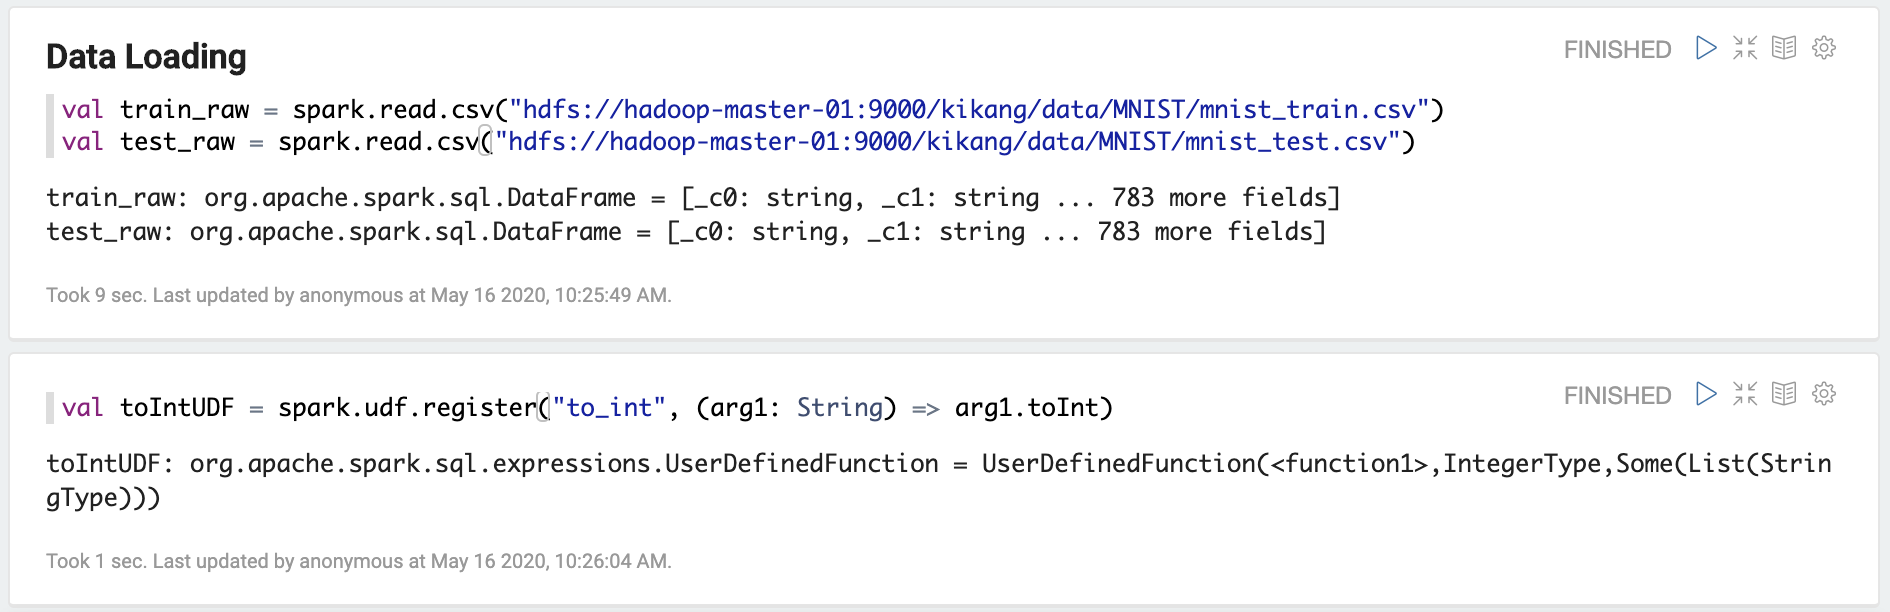

In [4]:
Image('./capture/03_mnist.png')

In [ ]:
val cols = 0 to 784
val colsStr = cols.map(i => {
    if(i == 0)
        s"""to_int(_c$i) as label"""
    else
        s"""to_int(_c$i) as pixel${i-1}"""
}).mkString(", ")

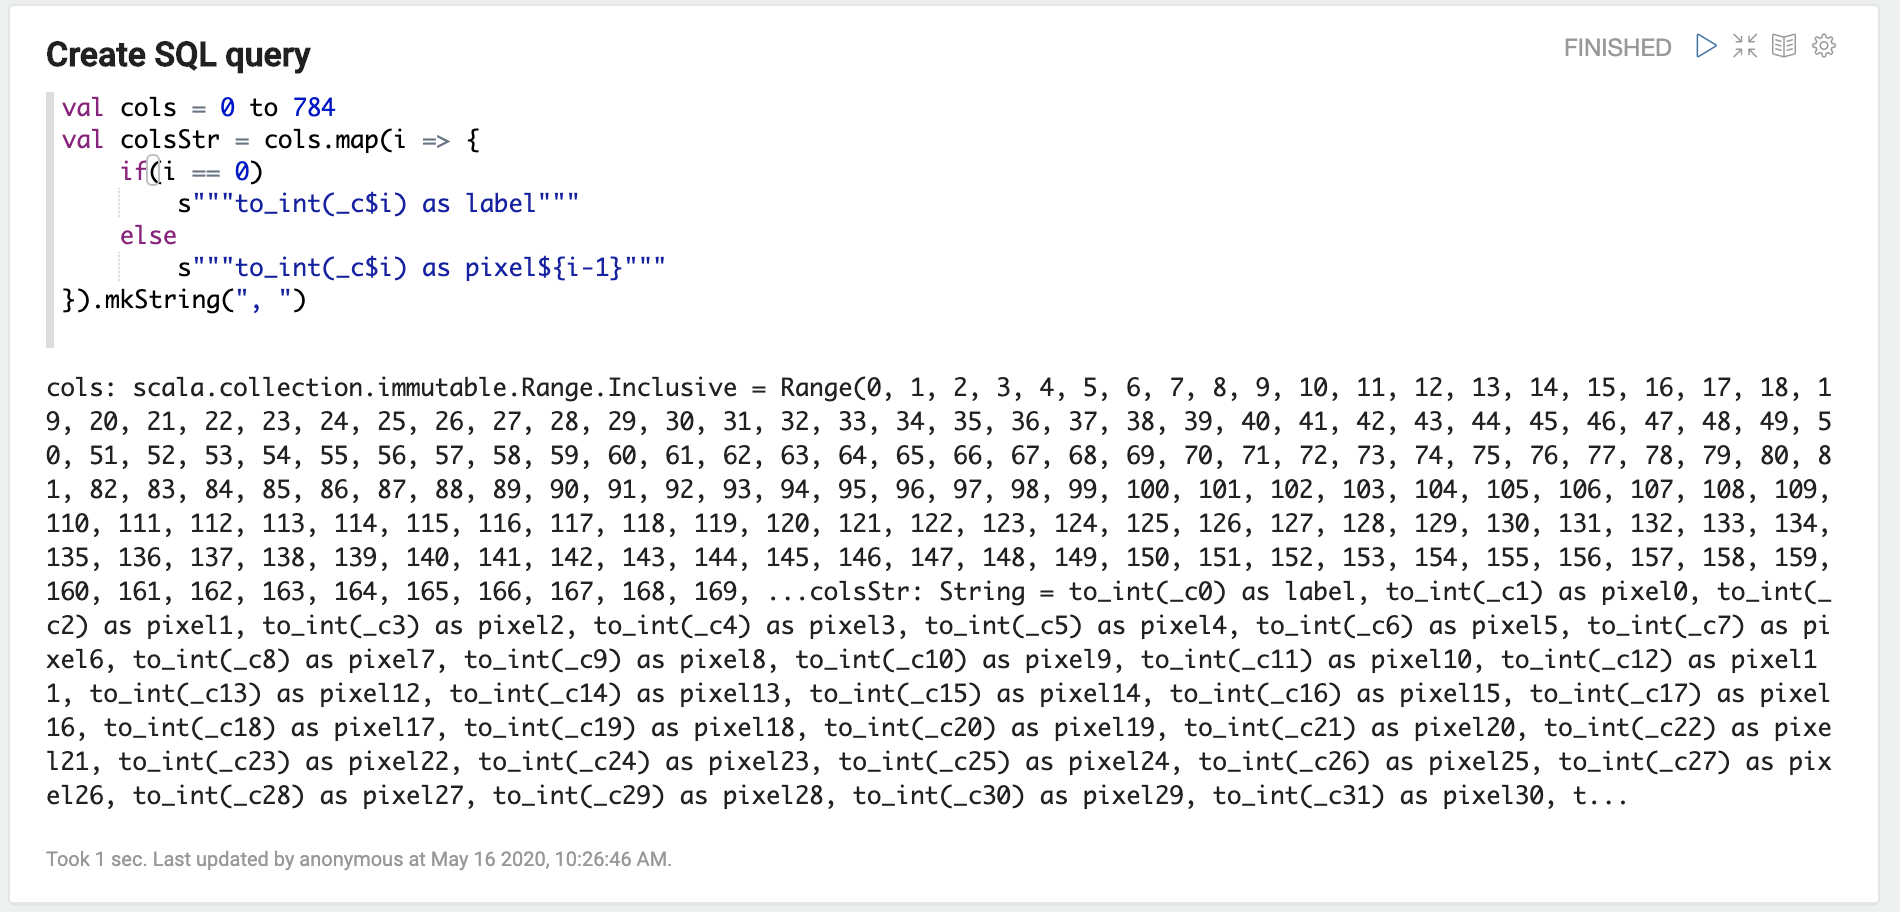

In [5]:
Image('./capture/04_mnist.png')

In [ ]:
val train_sql = s""" 
select 
    $colsStr 
from 
    train_raw
"""
        
val test_sql = s""" 
select 
    $colsStr 
from 
    test_raw
"""

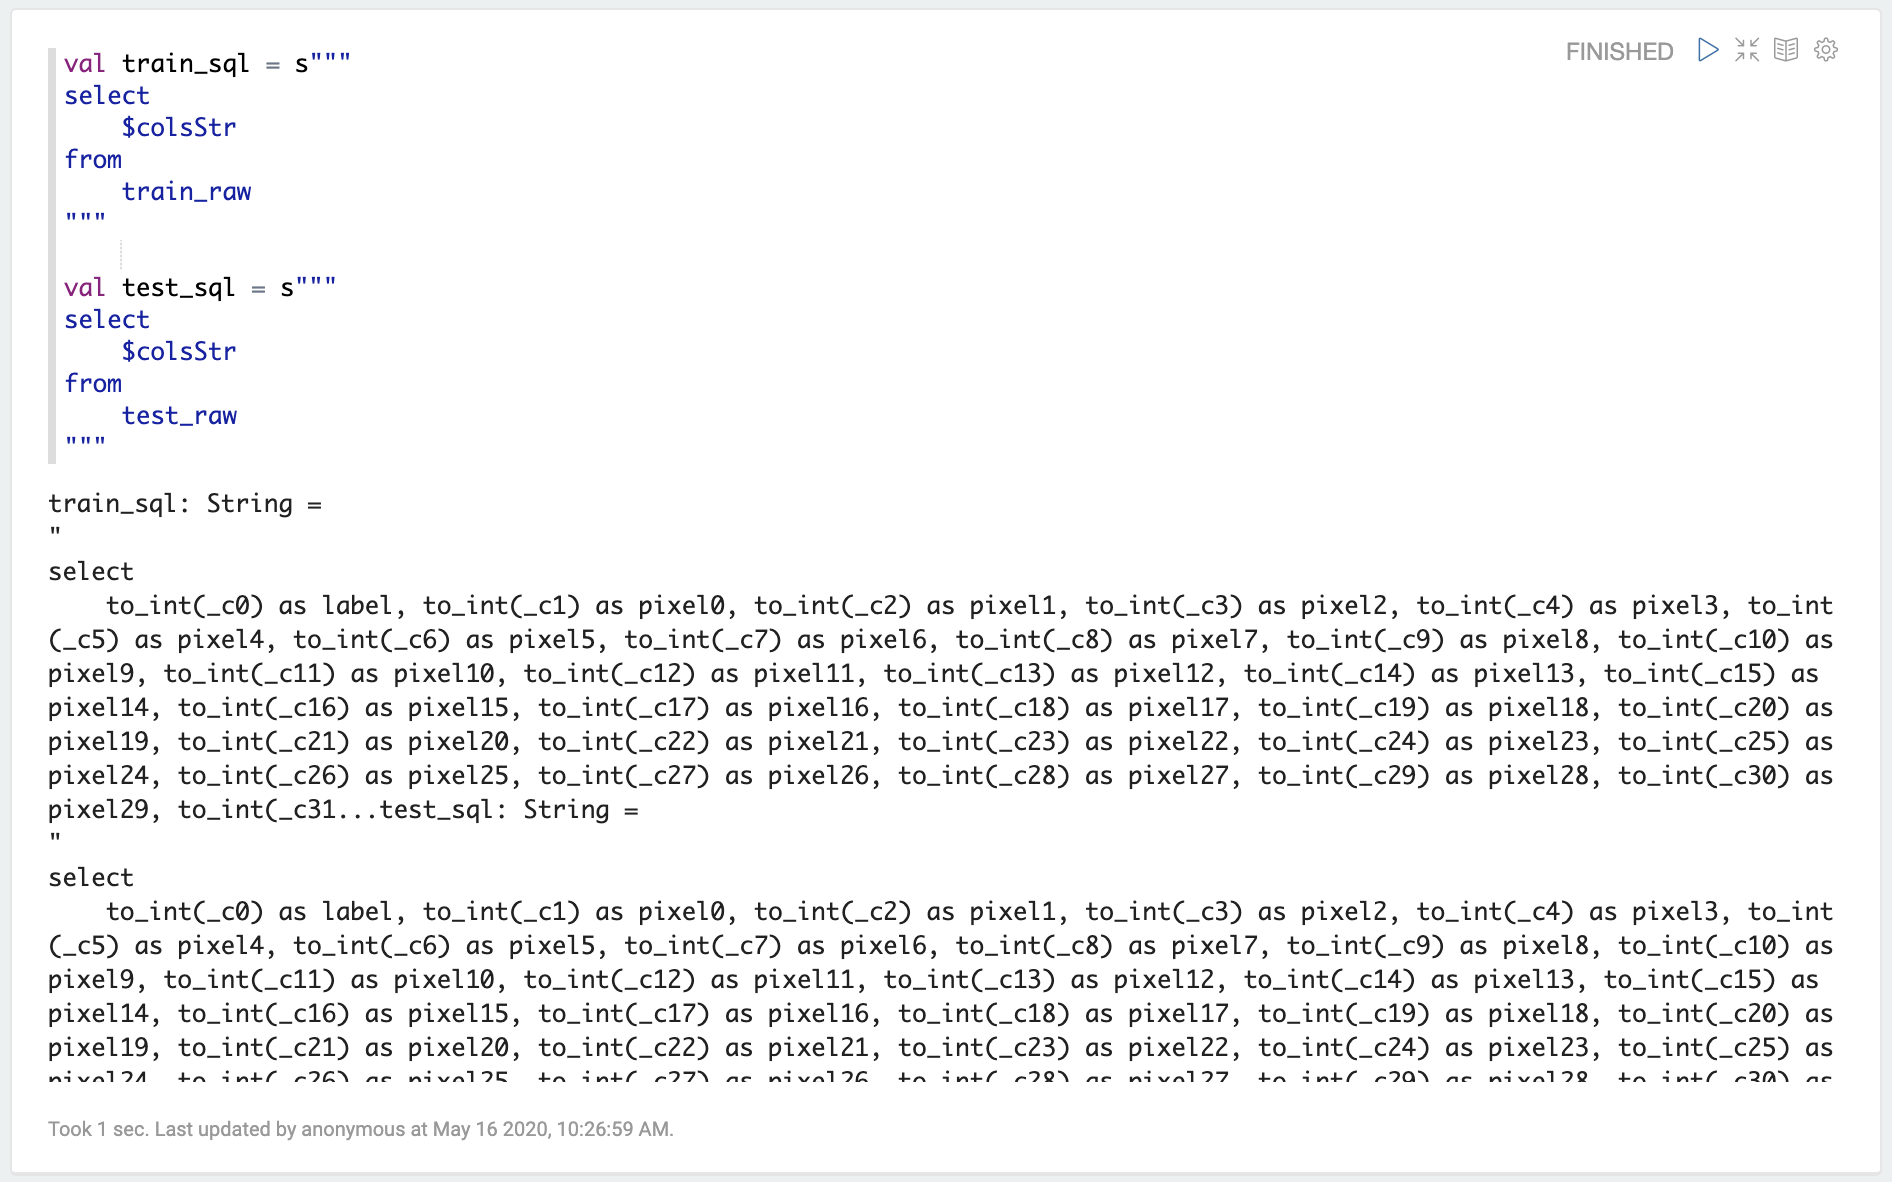

In [7]:
Image('./capture/05_mnist.png')

In [ ]:
val train = spark.sql(train_sql)
val test = spark.sql(train_sql)

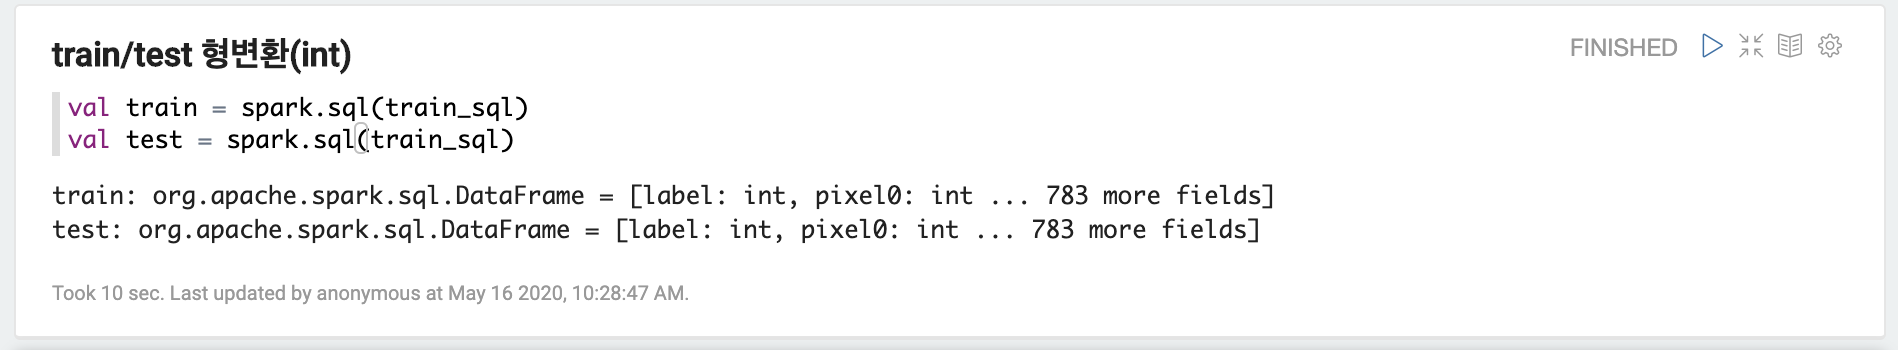

In [6]:
Image('./capture/06_mnist.png')

In [ ]:
val result = loaded_pipeline_model.transform(test)

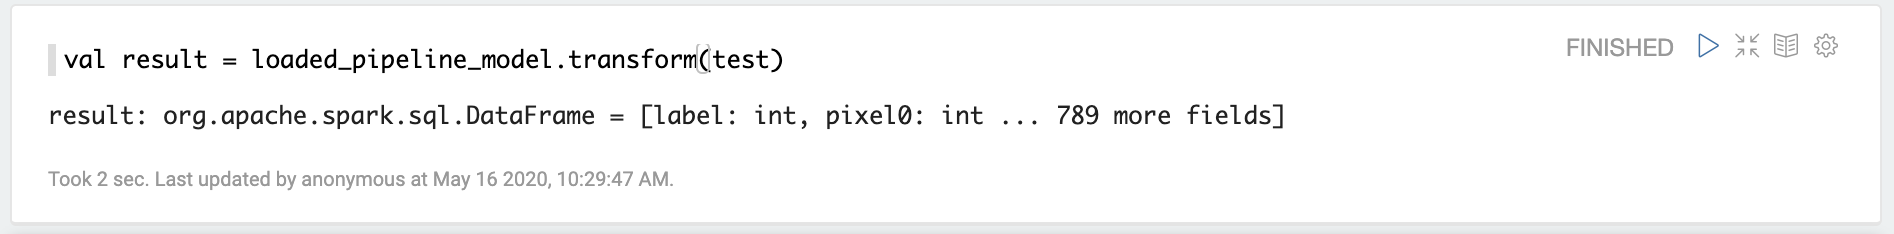

In [3]:
Image('./capture/02_mnist.png')

### 성능 좋은 모델 평가를 위한 Evaluator 생성

In [ ]:
result.printSchema

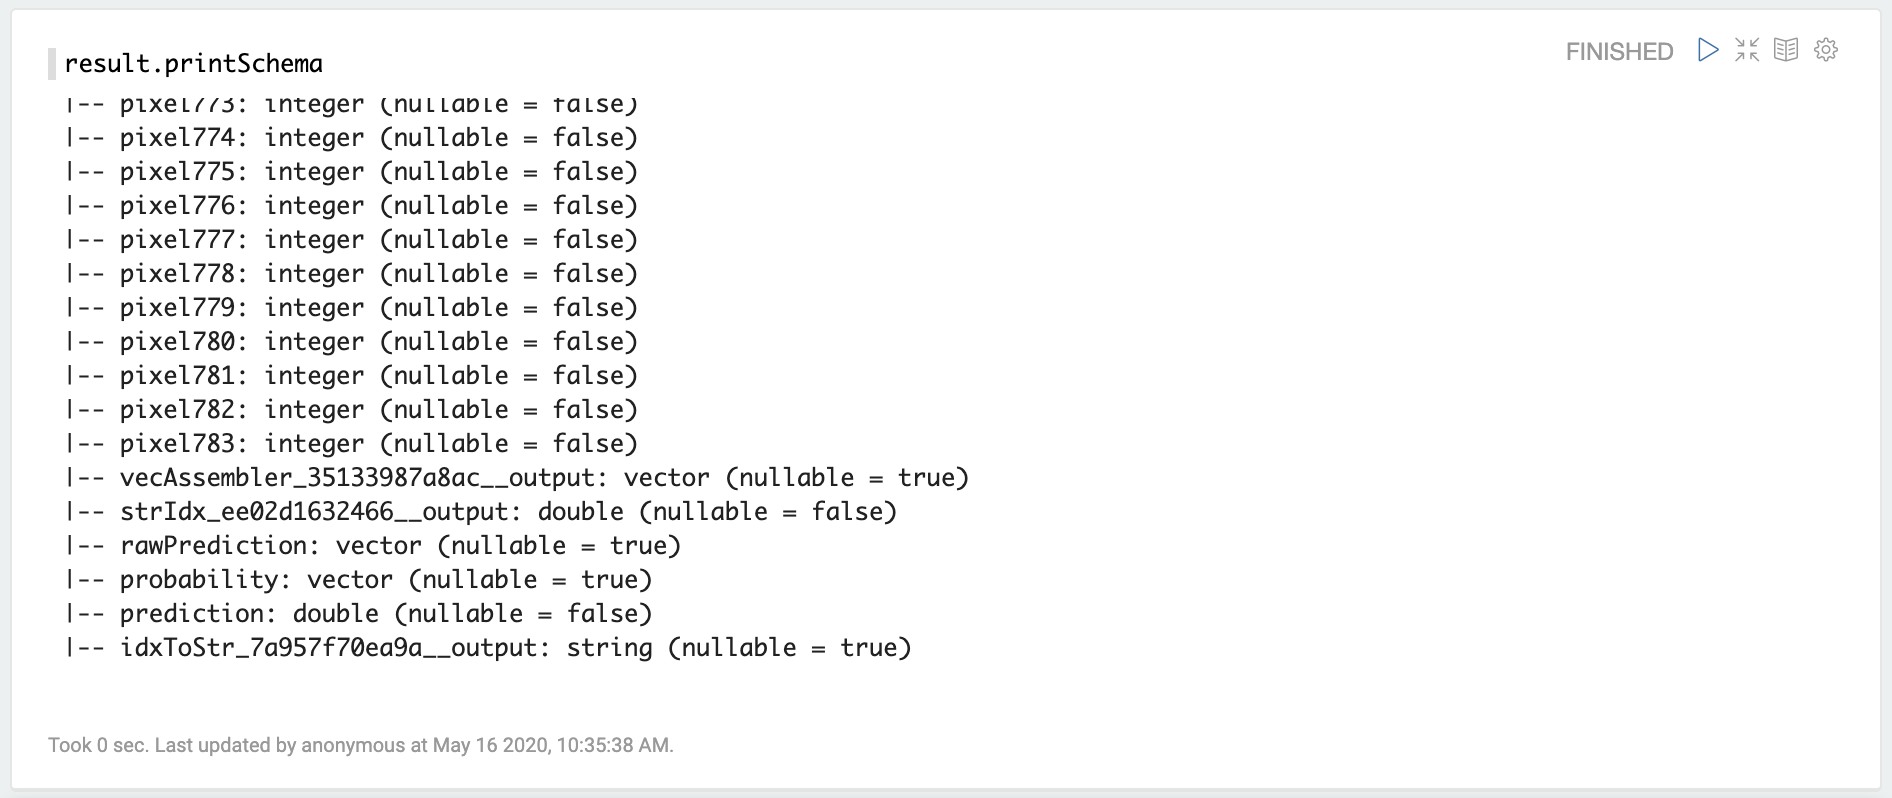

In [8]:
Image('./capture/07_mnist.png')

In [ ]:
import org.apache.spark.ml.evaluation.{MulticlassClassificationEvaluator}

val evaluator = { new MulticlassClassificationEvaluator()  
  .setLabelCol("strIdx_ee02d1632466__output")
  .setPredictionCol("prediction")
  .setMetricName("accuracy")
}

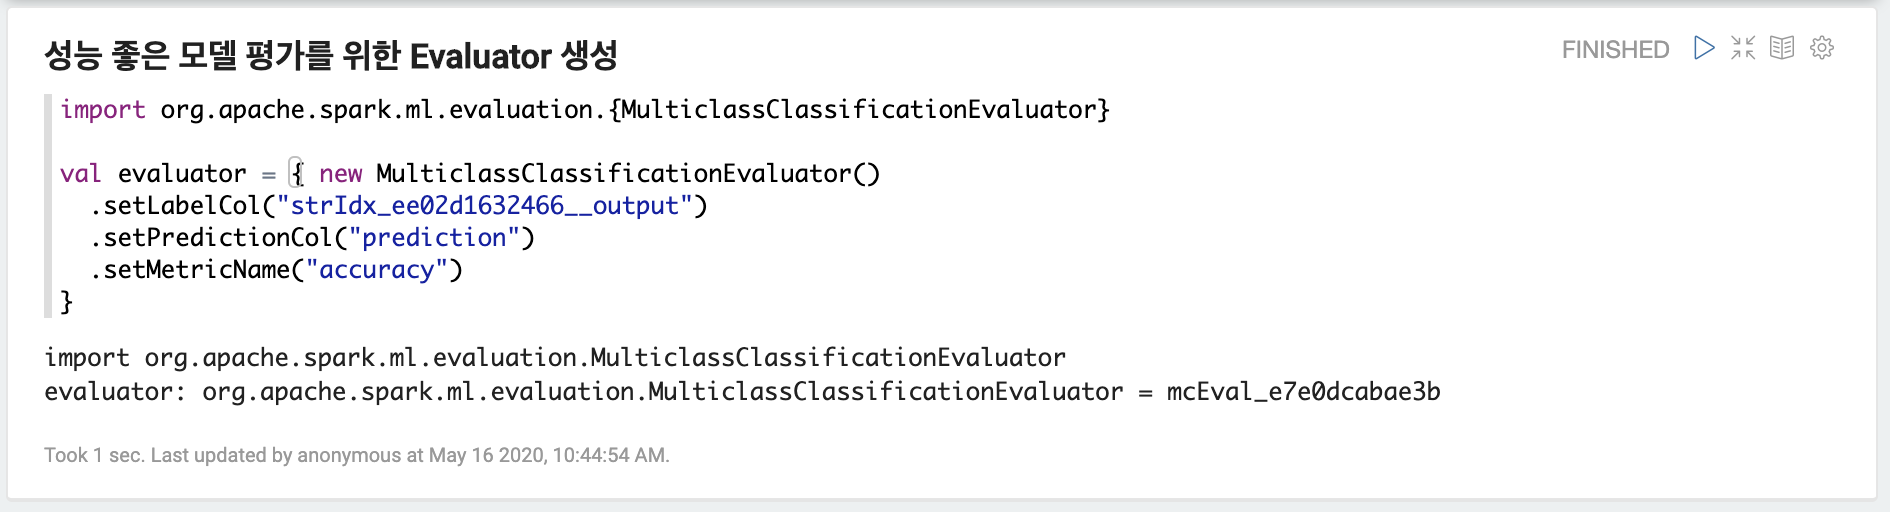

In [9]:
Image('./capture/08_mnist.png')

### 모델 성능 평가

In [ ]:
val precision = evaluator.evaluate(result)

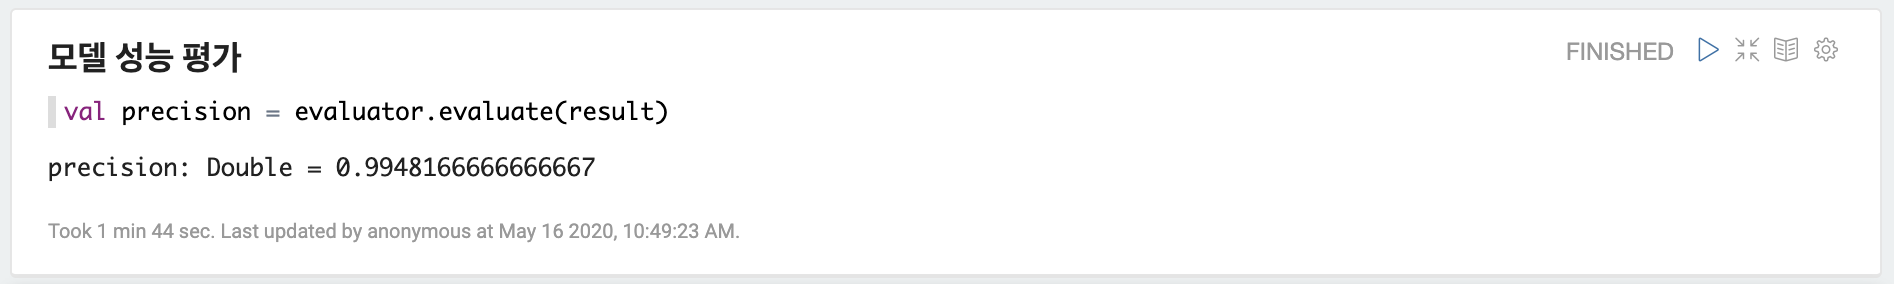

In [12]:
Image('./capture/09_mnist.png')

--- 
### String Index

 - 우리가 궁금한 것은 string( ex) 개, 고양이 )

-----

 |-- vecAssembler_35133987a8ac__output: vector (nullable = true)\
 |-- strIdx_ee02d1632466__output: double (nullable = false)\
 |-- rawPrediction: vector (nullable = true)\
 |-- probability: vector (nullable = true)\
 |-- prediction: double (nullable = false)\
 |-- idxToStr_7a957f70ea9a__output: string (nullable = true)
 
----- 
- idxToStr_7a957f70ea9a__output: string (nullable = true)
 :  우리가 필요한 값
 



### 성능 좋은 모델에 대한 confusion Matrix 생성

In [ ]:
val confusionMatrix = {   
      result.select("label","idxToStr_7a957f70ea9a__output")
            .orderBy("label")
            .groupBy("label")
            .pivot("idxToStr_7a957f70ea9a__output", Seq("4"))
            .count
    }

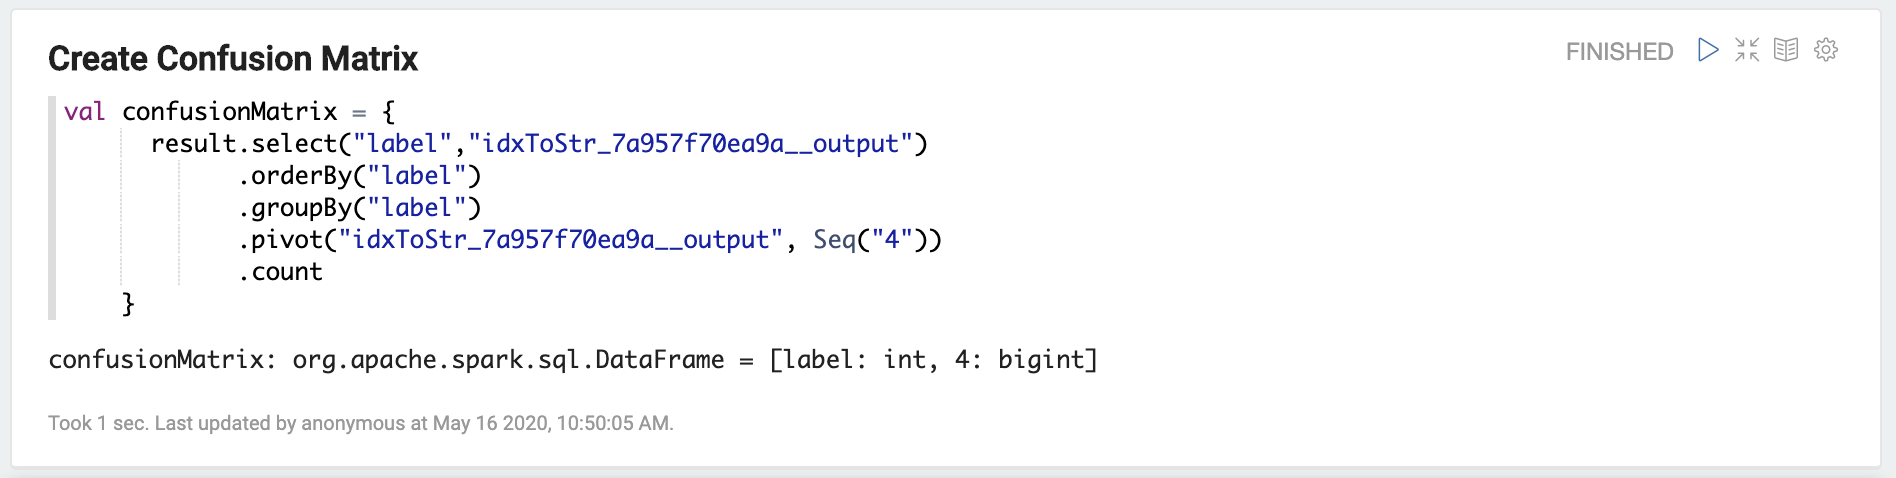

In [13]:
Image('./capture/10_mnist.png')

### 성능 좋은 모델에 대한 confusion Matrix 출력

In [ ]:
println(s"Confusion Matrix (Vertical: Actual, Horizontal: Predicted):")  
    confusionMatrix.show

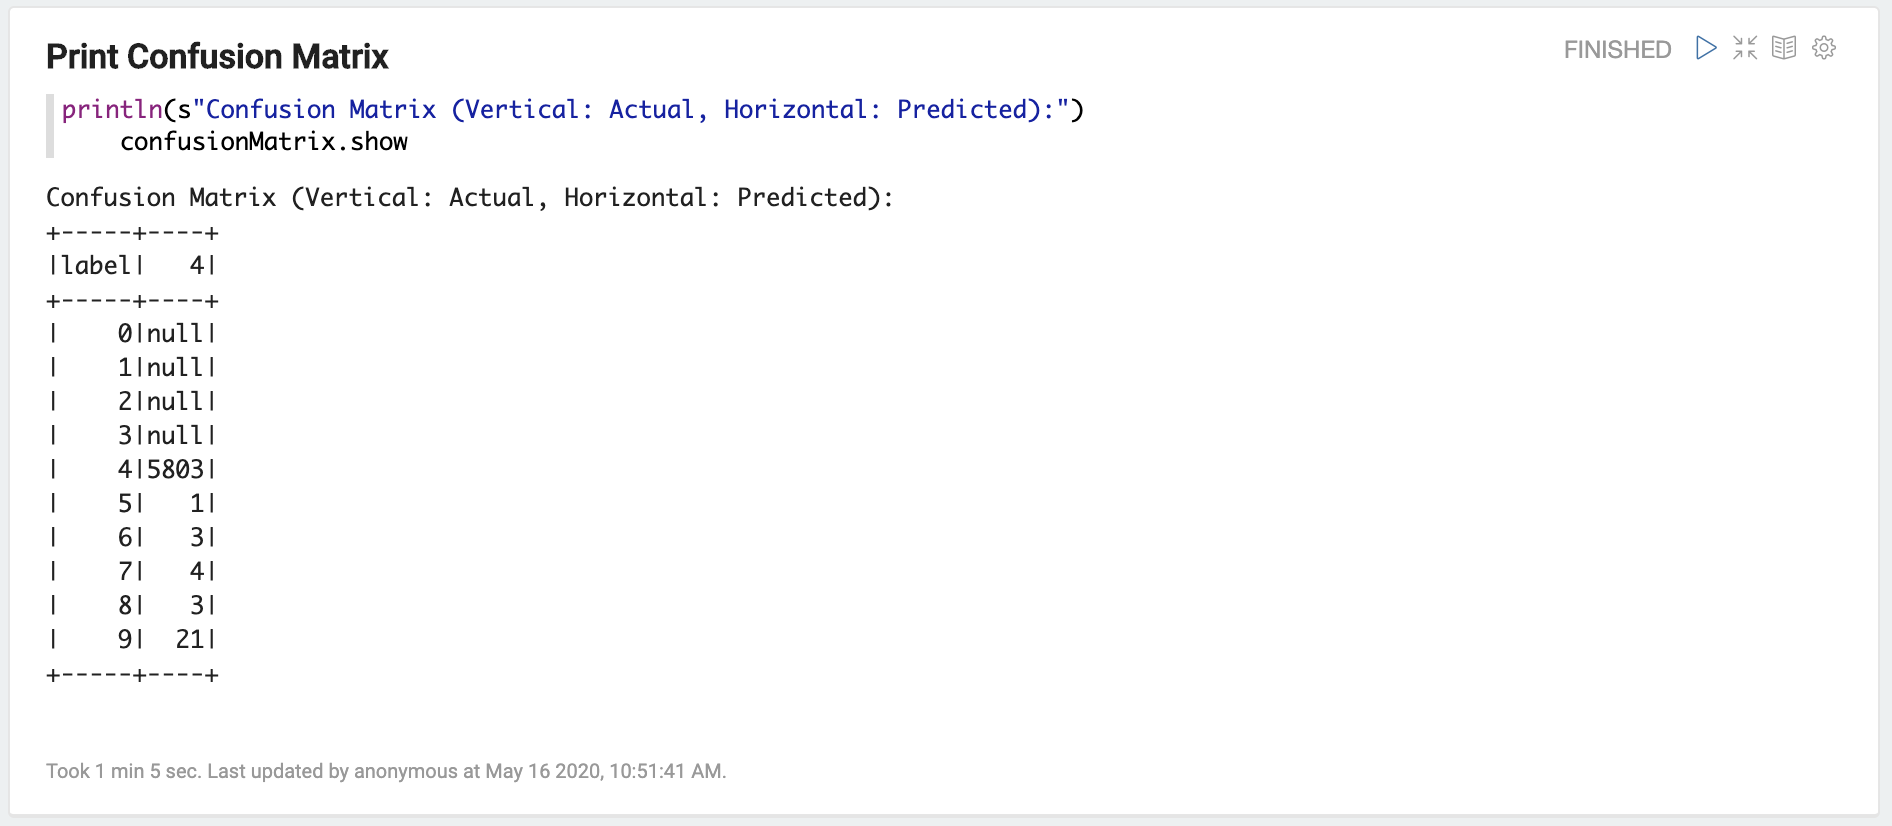

In [14]:
Image('./capture/11_mnist.png')

- map : 결과 출력 
- foreach : 결과를 출력하지 않음 

----
### 0 - 9 까지의 confusion matrix 생성

In [ ]:
val confusionMatrix = {   
      result.select("label","idxToStr_7a957f70ea9a__output")
            .orderBy("label")
            .groupBy("label")
            .pivot("idxToStr_7a957f70ea9a__output", (0 to 9).map(_.toString).toSeq)
            .count
    }

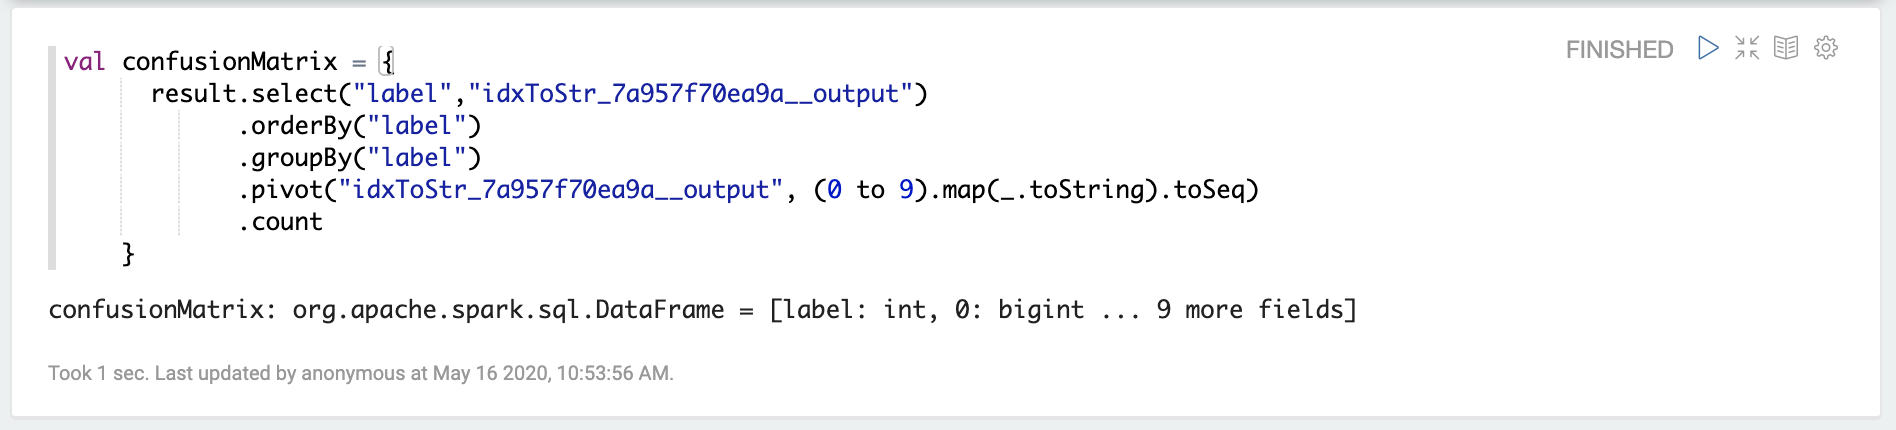

In [15]:
Image('./capture/12_mnist.png')

### confusion matrix 출력

In [ ]:
println(s"Confusion Matrix (Vertical: Actual, Horizontal: Predicted):")  
    confusionMatrix.show

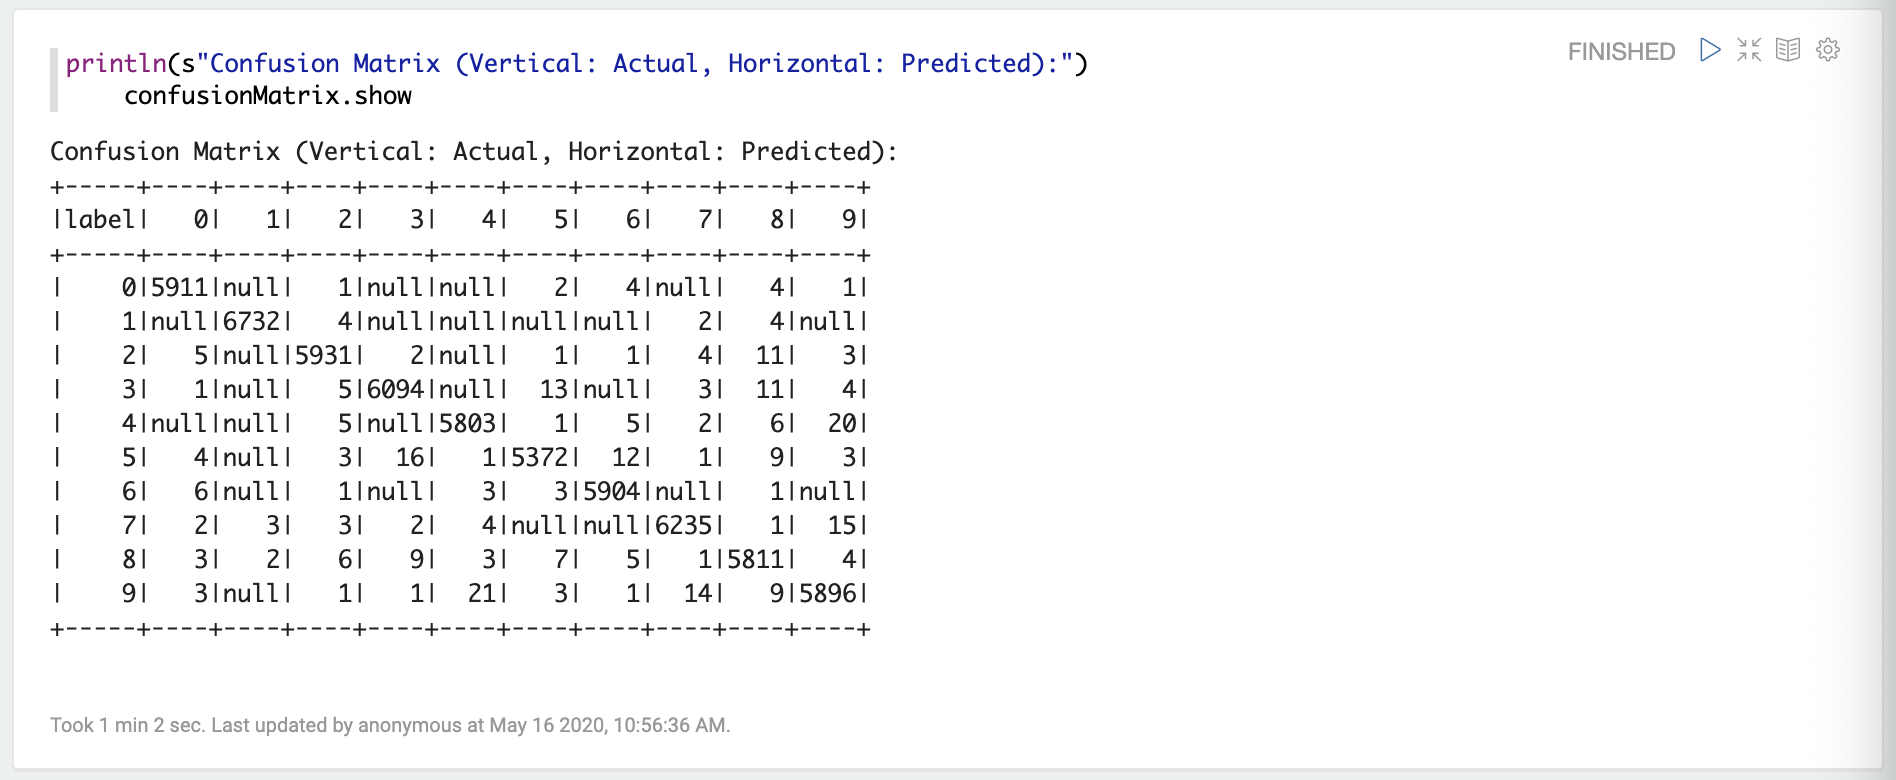

In [16]:
Image('./capture/13_mnist.png')

-------


### test 화면 구성 step01

In [ ]:
println("""
%angular




<table>
    <tr>
        <td style="border-style: none;">
            <b align="center"> * Write Digit (0~9) </b>
            <div style="border: solid 2px #666; width: 143px; height: 144px;">
                <canvas width="140" height="140"></canvas>
            </div>
        </td>
        <td style="border-style: none;">
            <button onclick="clear_value()">Clear</button>
        </td>
        <td style="border-style: none;">
       <!-- <button onclick="predict()" >Predict</button> -->
       <!-- <button onclick="predict()" ng-click="z.runParagraph('20200210-091626_755565815')">Predict</button> -->
            <button ng-click="predict2(z)">Predict2</button>
        </td>
        <td style="border-style: none;">
            <b align="center"> * Predicted Result </b>
       <!-- <div style="border: solid 0px #666; width: 143px; height: 144px;" id="predict_result"></div> -->

            <br>
            <!-- model "ml_predict_result" -->
            <input type="text" id="predict_result" style="border: solid 2px #666; width: 143px; height: 144px; text-align: center;" ng-model="ml_predict_result">

        </td>
    </tr>
</table>




<!-- model "digit_features" -->
<textarea id="textarea_data" rows="24" cols="56" ng-model="digit_features"></textarea>




<script type="text/Javascript">

    //--added by kikang....
    document.getElementById("predict_result").style.textAlign = "center";
    document.getElementById("predict_result").style.verticalAlign = "middle";
    document.getElementById("predict_result").style.fontSize = "100px";

    var pixels = [];
    for (var i = 0; i < 28*28; i++) pixels[i] = 0	//--784....
    var click = 0;

    var canvas = document.querySelector("canvas");
    canvas.addEventListener("mousemove", function(e){
        if (e.buttons == 1) {
            click = 1;
            canvas.getContext("2d").fillStyle = "rgb(0,0,0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 8, 8);
            x = Math.floor(e.offsetY * 0.2)
            y = Math.floor(e.offsetX * 0.2) + 1
            for (var dy = 0; dy < 2; dy++){
                for (var dx = 0; dx < 2; dx++){
                    if ((x + dx < 28) && (y + dy < 28)){
                        //pixels[(y+dy)+(x+dx)*28] = 1
                        pixels[(y+dy)+(x+dx)*28] = 254
                    }
                }
            }
        } else {
            if (click == 1) //set_value()
            click = 0;
        }
    });
    
    function set_value(){
        var result = ""
        for (var i = 0; i < 28*28; i++) result += pixels[i] + ","
        
        var textarea_data = document.getElementById("textarea_data");
        result = result.replace(/.$/,"")
        textarea_data.value = result;
        alert(textarea_data.value);
        
        //--call websocket.... => .$ will match any character at the end of a string. => label "9" 붙이기....
        //doSend("!!DIGIT_CSV!!" + "9," + result);
        //z.runParagraph("20200210-091626_755565815");  //--Run Paragraph.... 
    }
    
    function clear_value(){    	
        canvas.getContext("2d").fillStyle = "rgb(255,255,255)";
        canvas.getContext("2d").fillRect(0, 0, 140, 140);
        for (var i = 0; i < 28*28; i++) pixels[i] = 0
        
        //--added by kikang...
      //document.getElementById("predict_result").innerHTML = "";
        document.getElementById("predict_result").value = "";
        document.getElementById("textarea_data").value = "";
      //document.getElementById("output").innerHTML = "";
    }
    
    //--added by kikang....
    function predict() {
        set_value();

        document.getElementById("predict_result").innerHTML = "processing....";    	
    }
    
</script>








<!-- root div.... -->
<div id="rootDiv"></div>




<script>

//--get scope....
var rootDiv = $('#rootDiv');
var rootScope = angular.element(rootDiv.parent('.ng-scope')).scope().compiledScope;

//--define function "predict2()"....
rootScope.predict2 = function(z) {
    var result = "";
    for (var i = 0; i < 28*28; i++) result += pixels[i] + ",";
    
    result = result.replace(/.$/,"");
    rootScope.digit_features = result;
    alert(rootScope.digit_features);
    
    rootScope.ml_predict_result = "....";    	
    
    z.runParagraph("20200210-091626_755565815");  //--Run Paragraph.... 
};

</script>






""")

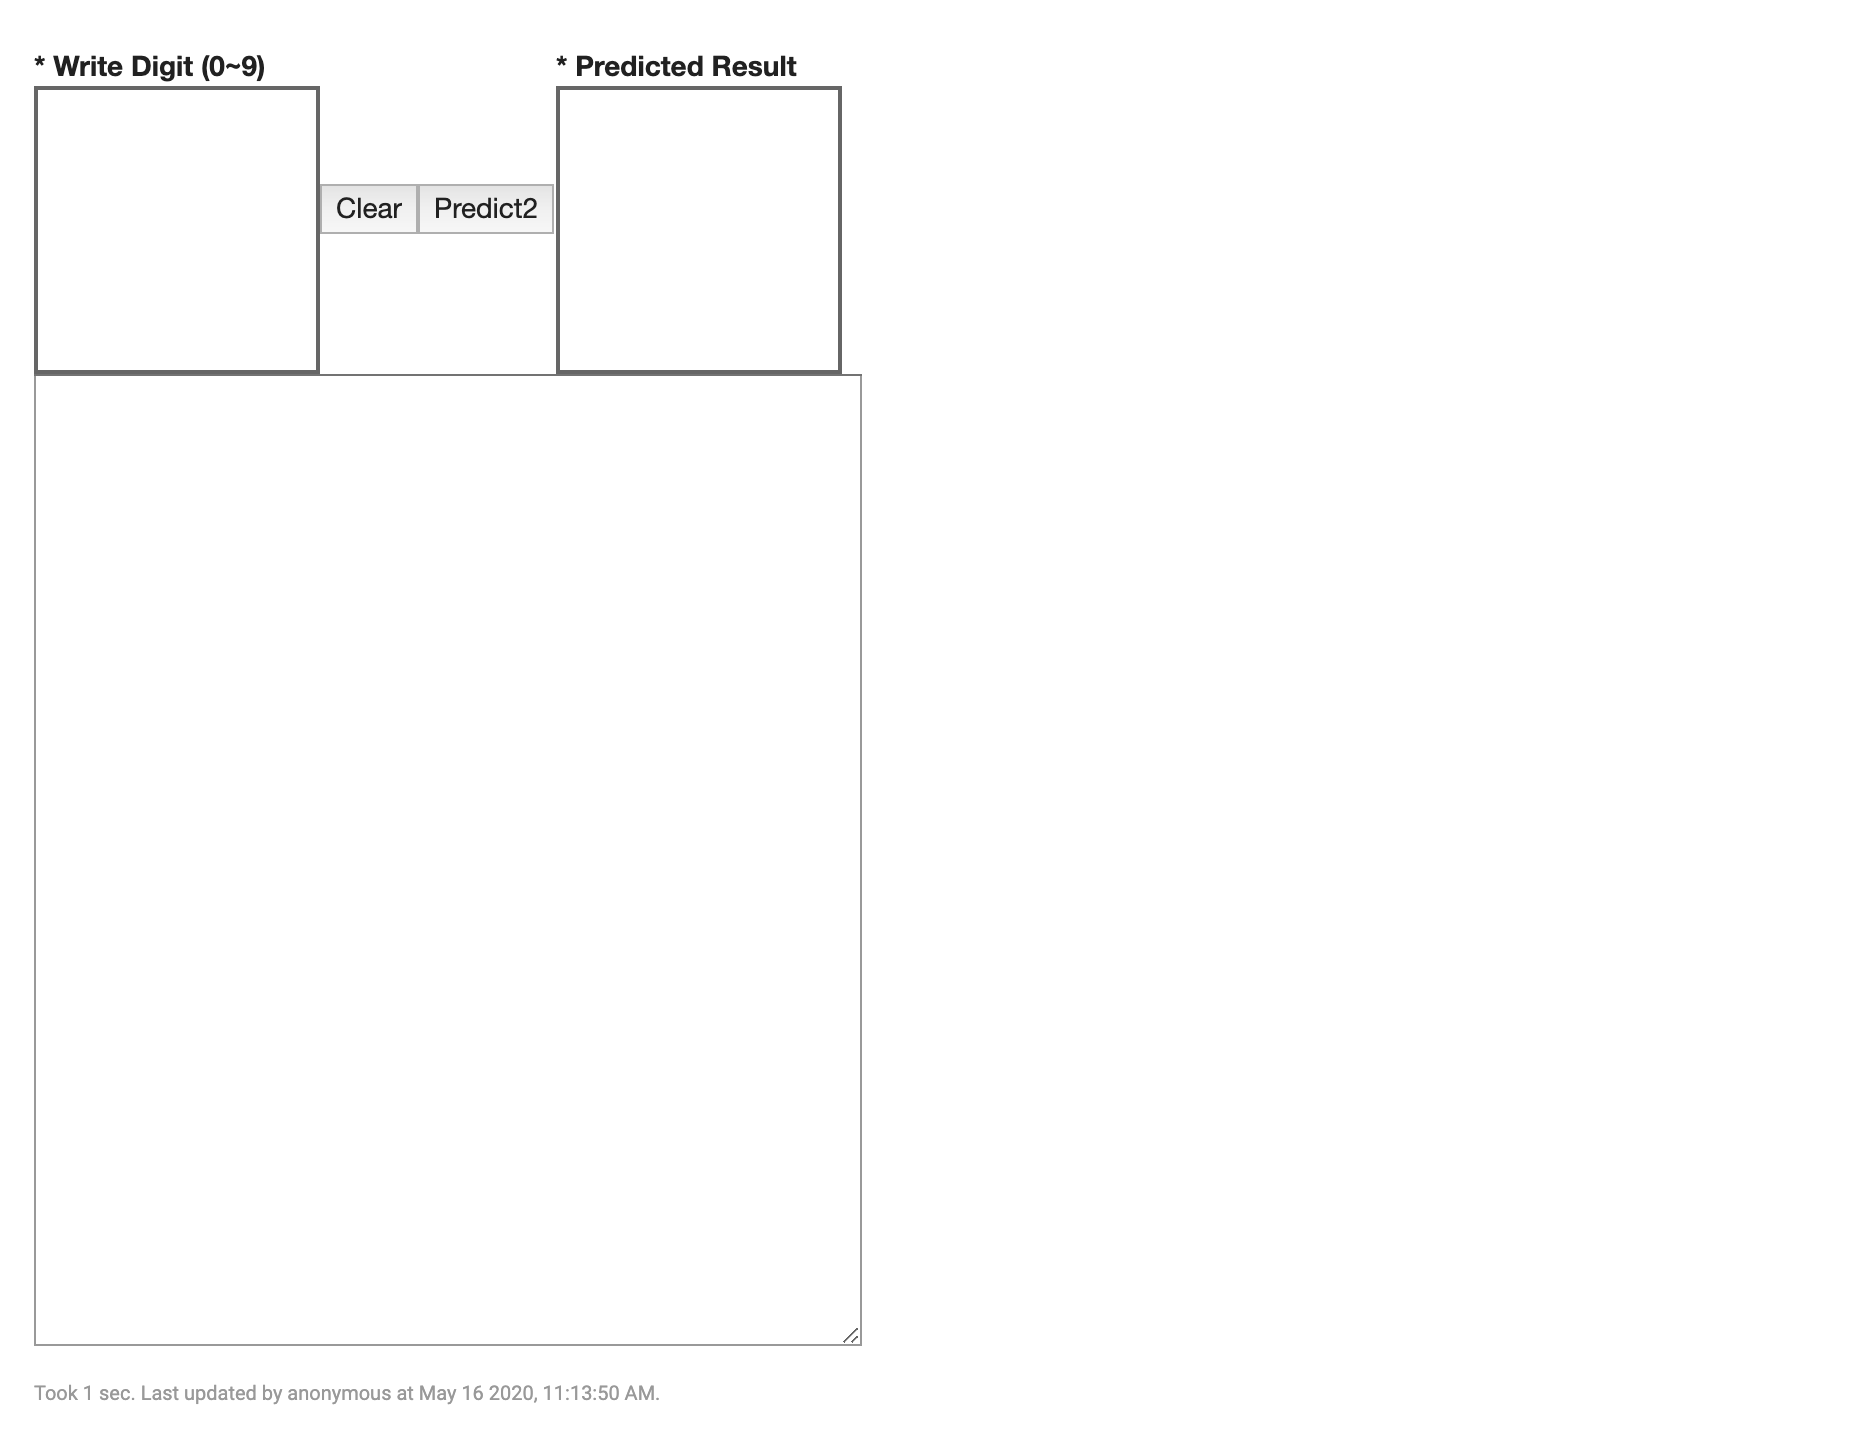

In [18]:
Image('./capture/14_mnist.png')

---- 
#### z : zeppelin code 
 
 - angular 연결 

In [ ]:
z

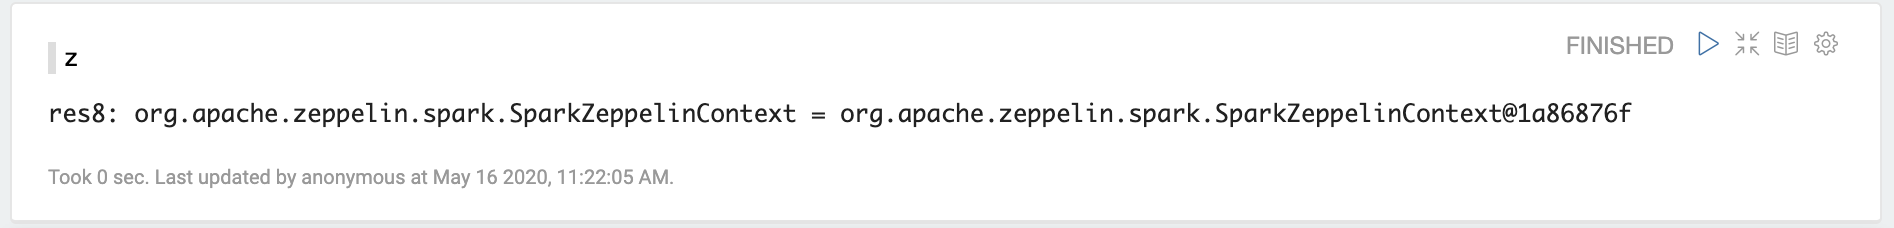

In [19]:
Image('./capture/15_mnist.png')

--- 
#### column명을 지정하지 않으면 default 는 value.

In [ ]:
val csv = "1,2,3"
val seq = Seq(csv)

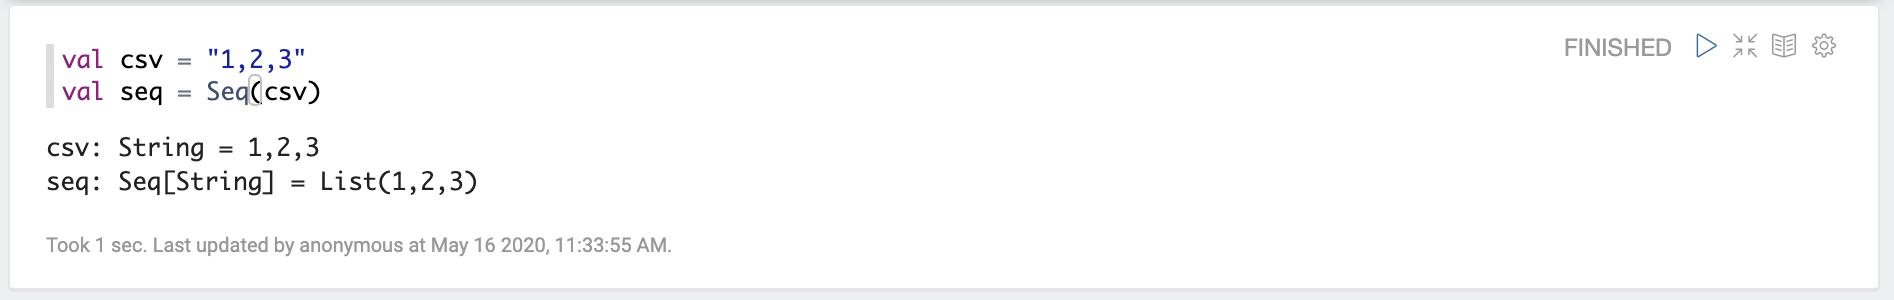

In [20]:
Image('./capture/16_mnist.png')

In [ ]:
val df = seq.toDF
df.printSchema

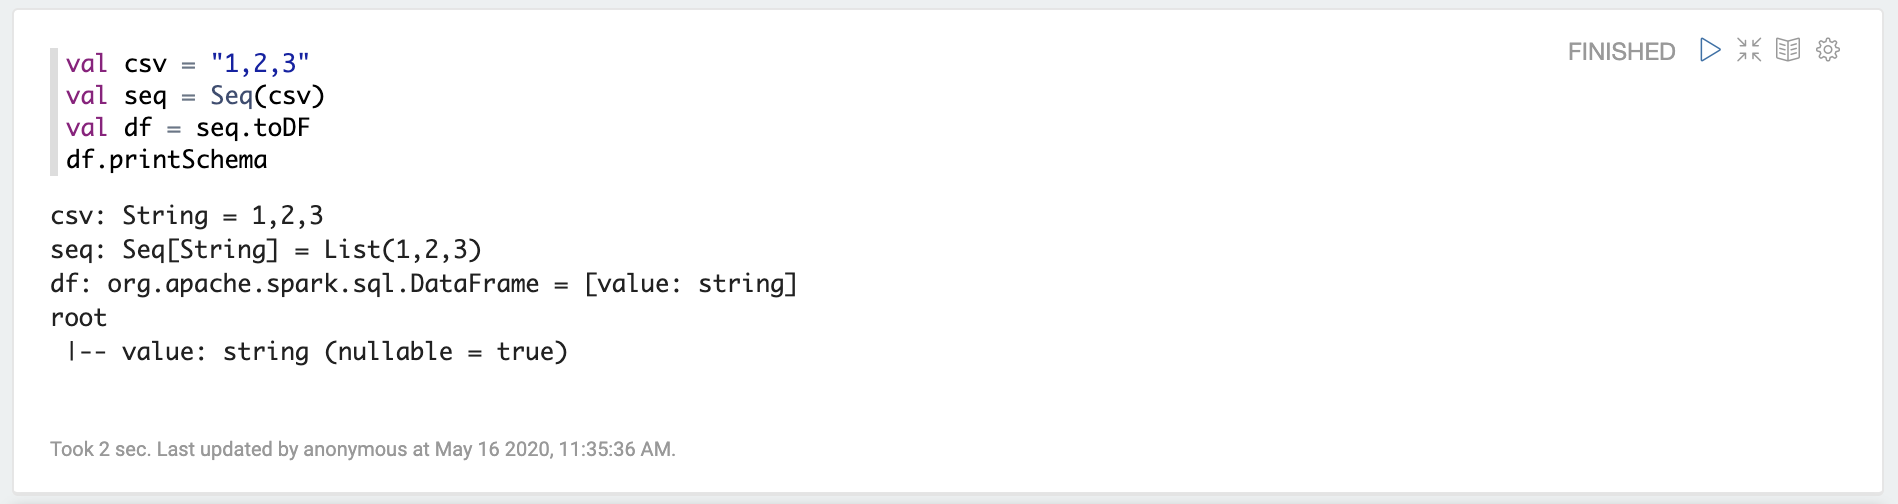

In [21]:
Image('./capture/17_mnist.png')

In [ ]:
val df2 = df.toDF("val")
df2.printSchema

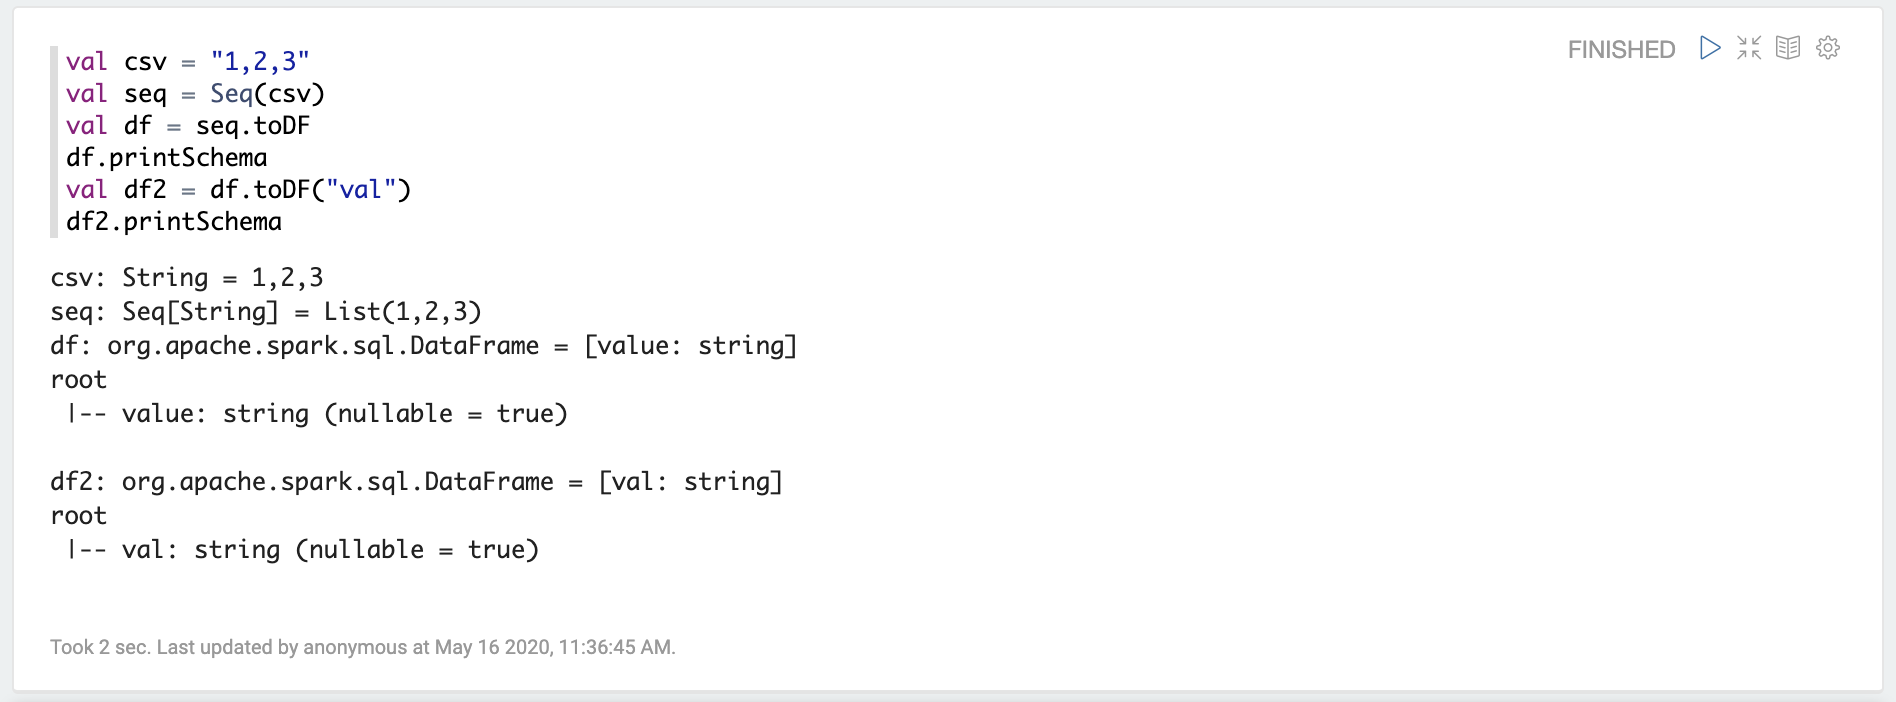

In [22]:
Image('./capture/18_mnist.png')

In [ ]:
df.show()

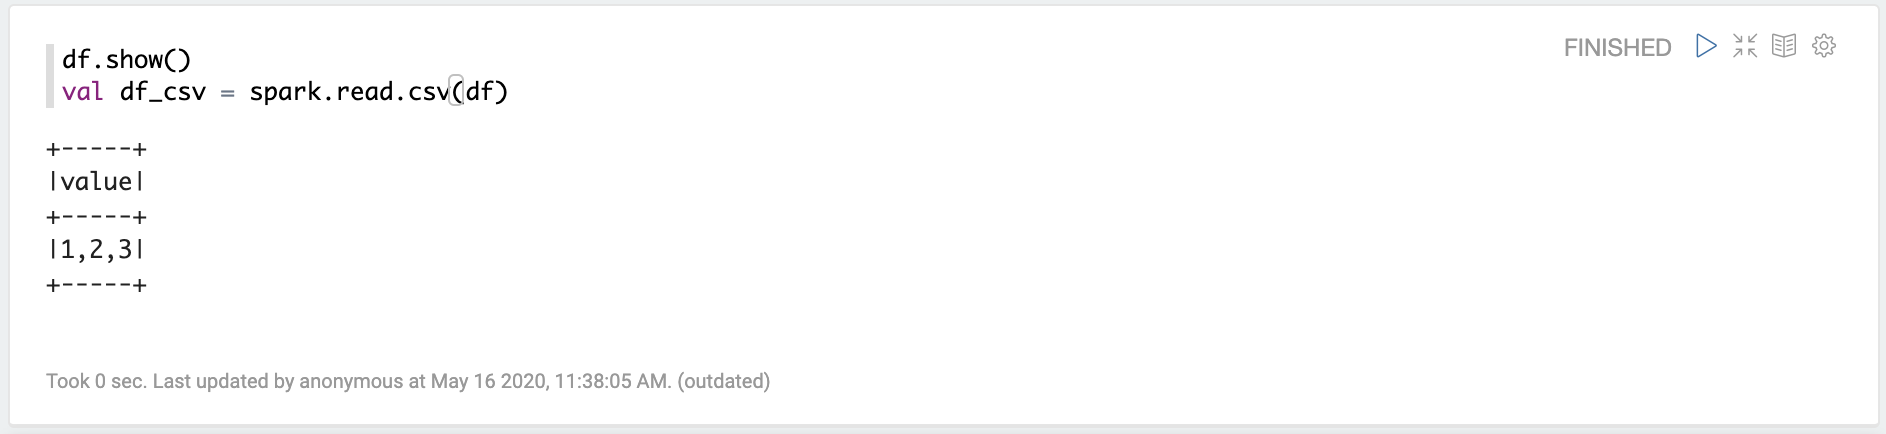

In [23]:
Image('./capture/19_mnist.png')

In [ ]:
val csv = "1,2,3"
val seq = Seq(csv)
val ds = seq.toDS
ds.printSchema
ds.show()
val df_csv = spark.read.csv(ds)
df_csv.printSchema

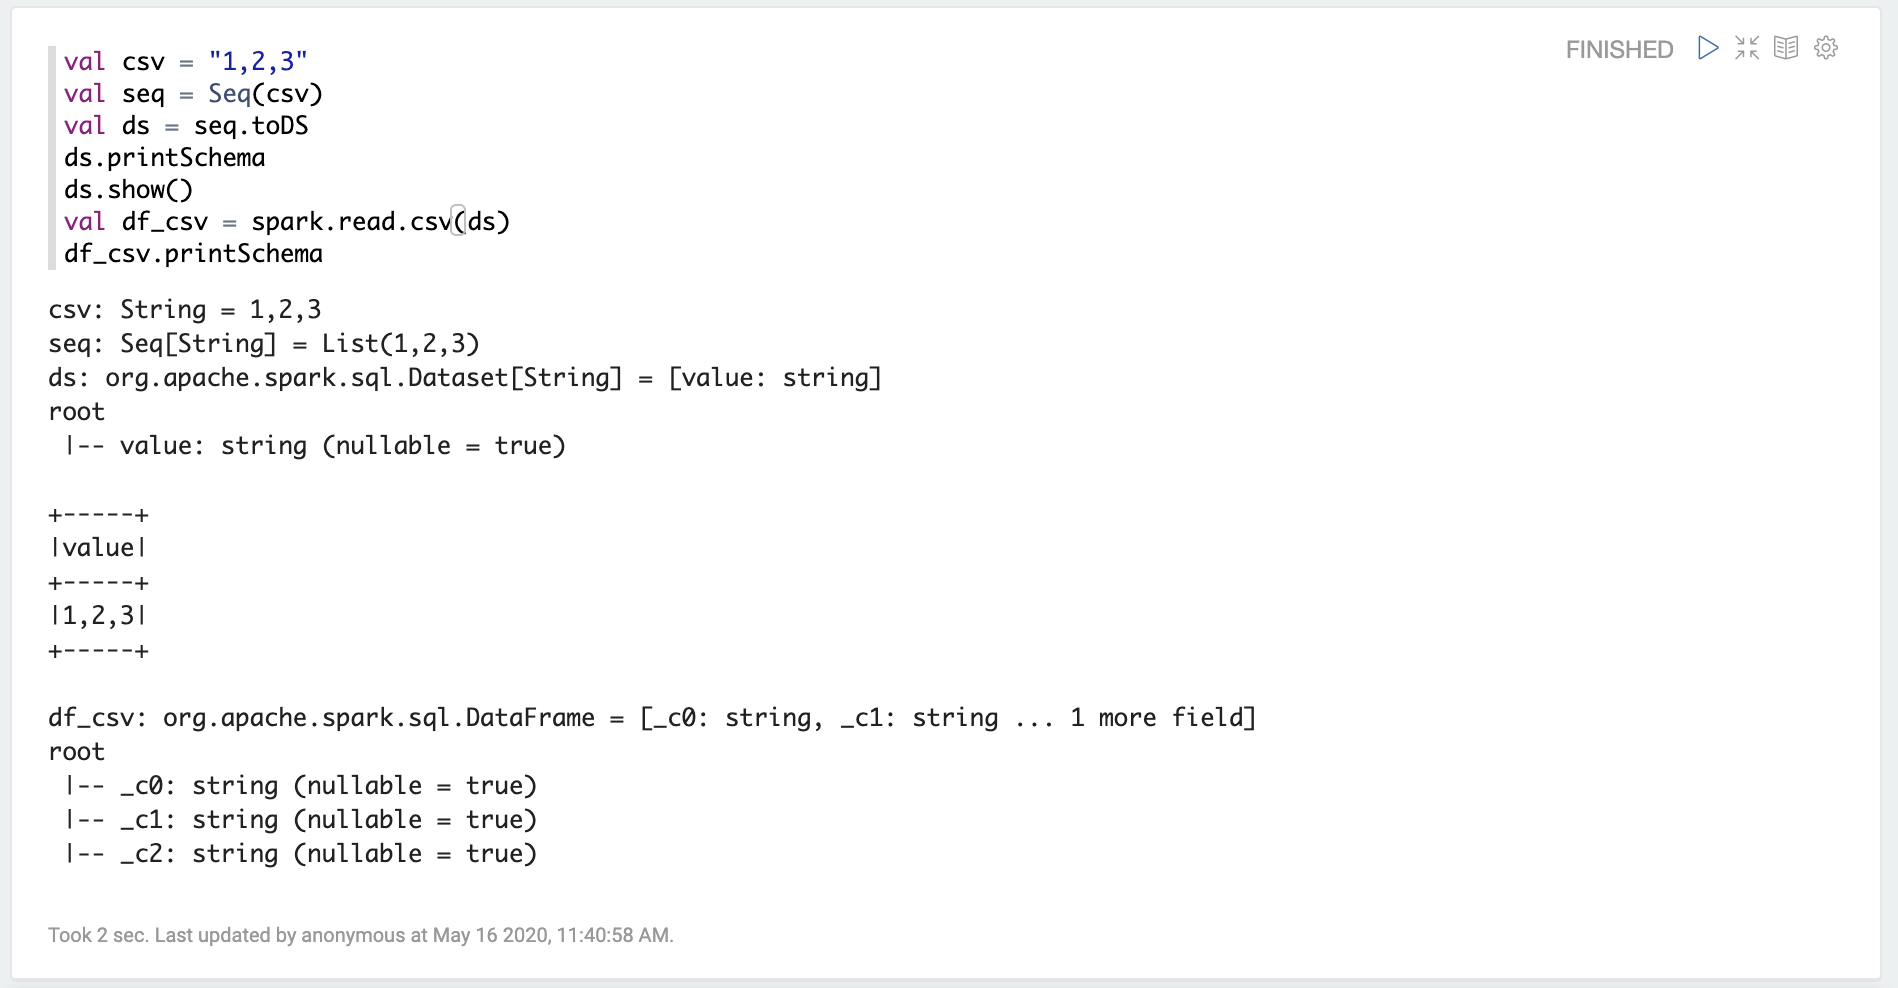

In [24]:
Image('./capture/20_mnist.png')

In [ ]:
val csv = "1,2,3"
val seq = Seq(csv)
val ds = seq.toDS
ds.printSchema
ds.show()
val df_csv = spark.read.csv(ds)
df_csv.printSchema
df_csv.toDF("col1","col2","col3").printSchema

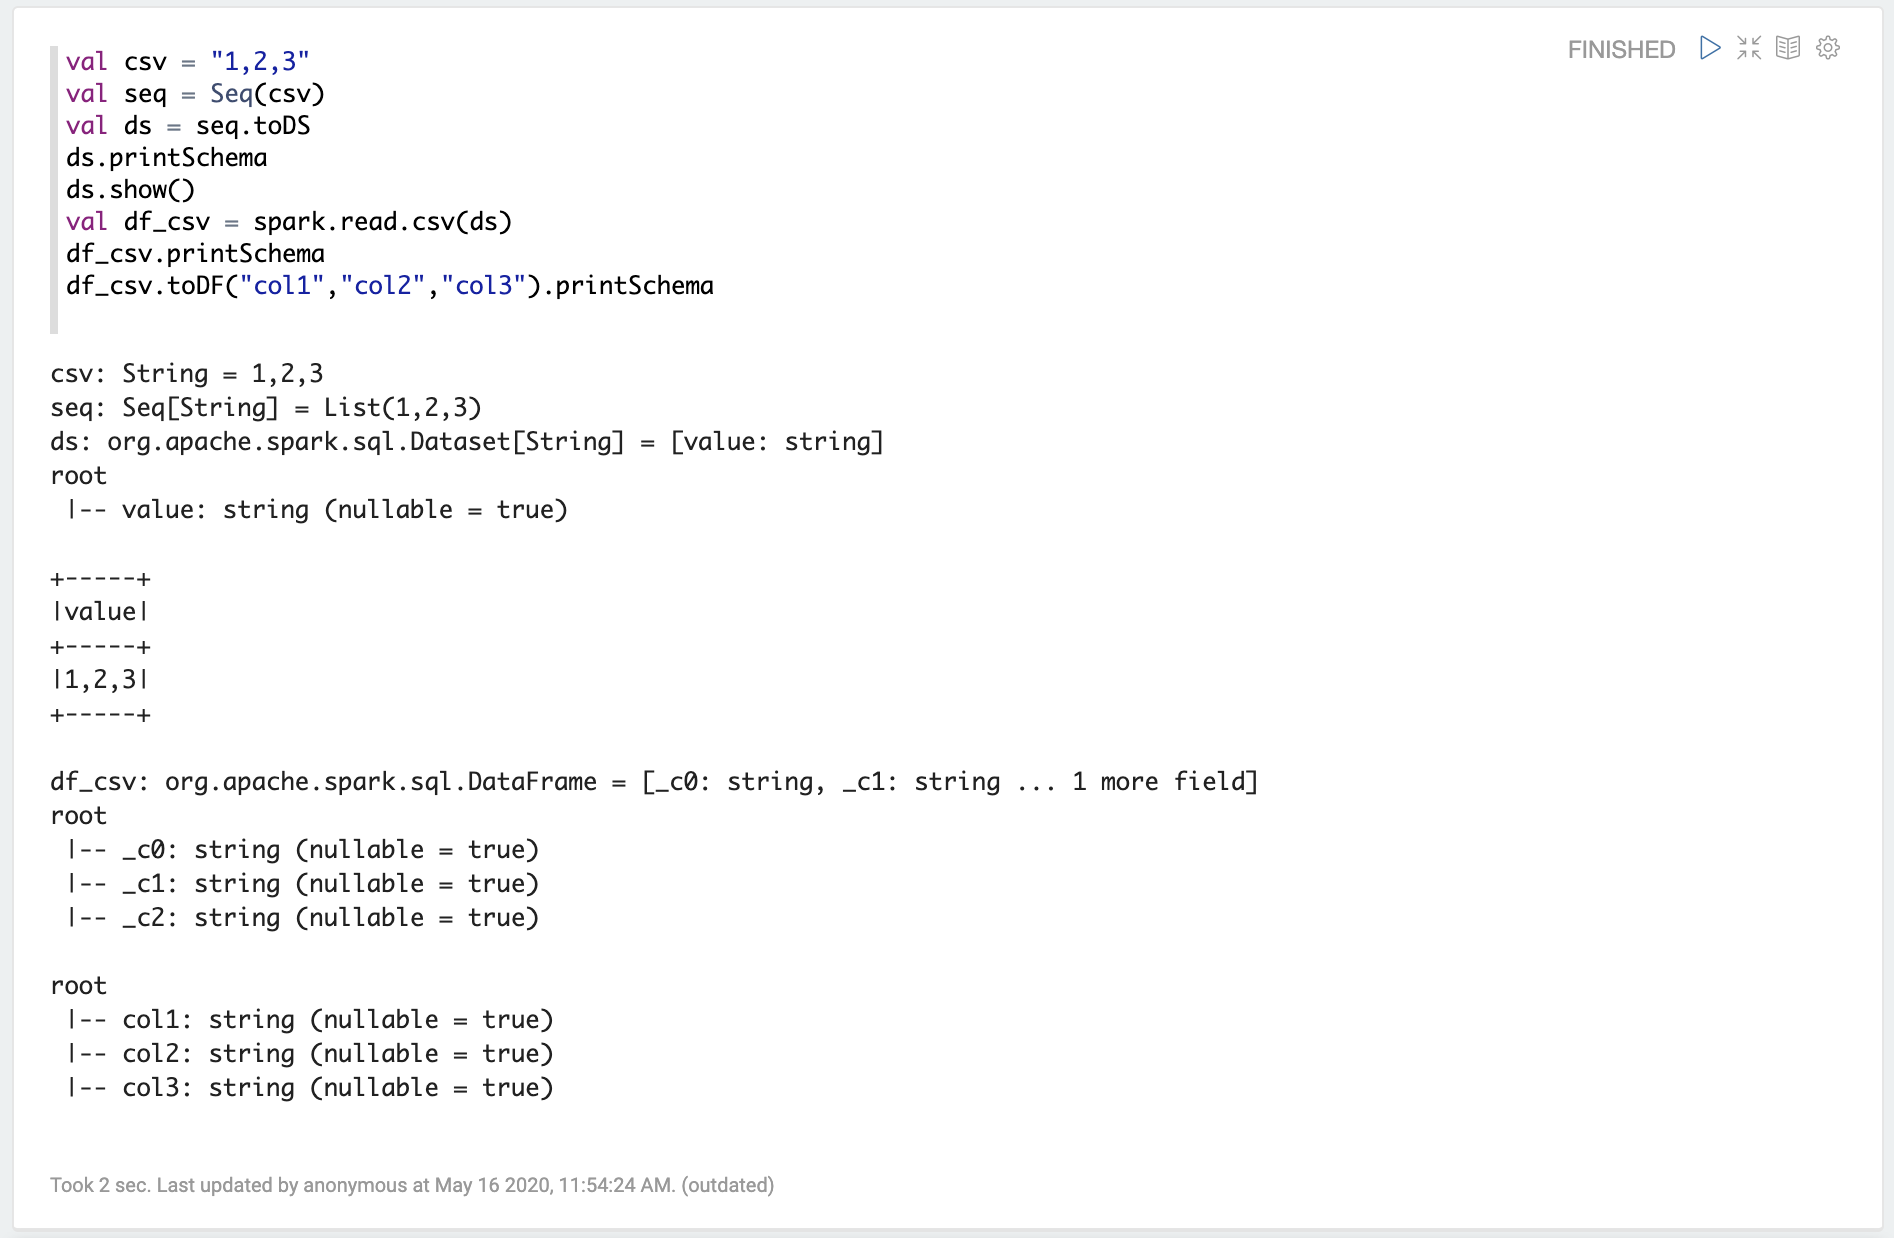

In [27]:
Image('./capture/23_mnist.png')

In [ ]:
val csv = "1,2,3"
val seq = Seq(csv)
val ds = seq.toDS
ds.printSchema
ds.show()
val df_csv = spark.read.csv(ds)
df_csv.printSchema
df_csv.toDF("col1","col2","col3").printSchema
df_csv.toDF((0 to 2).map(_.toString):_*).printSchema

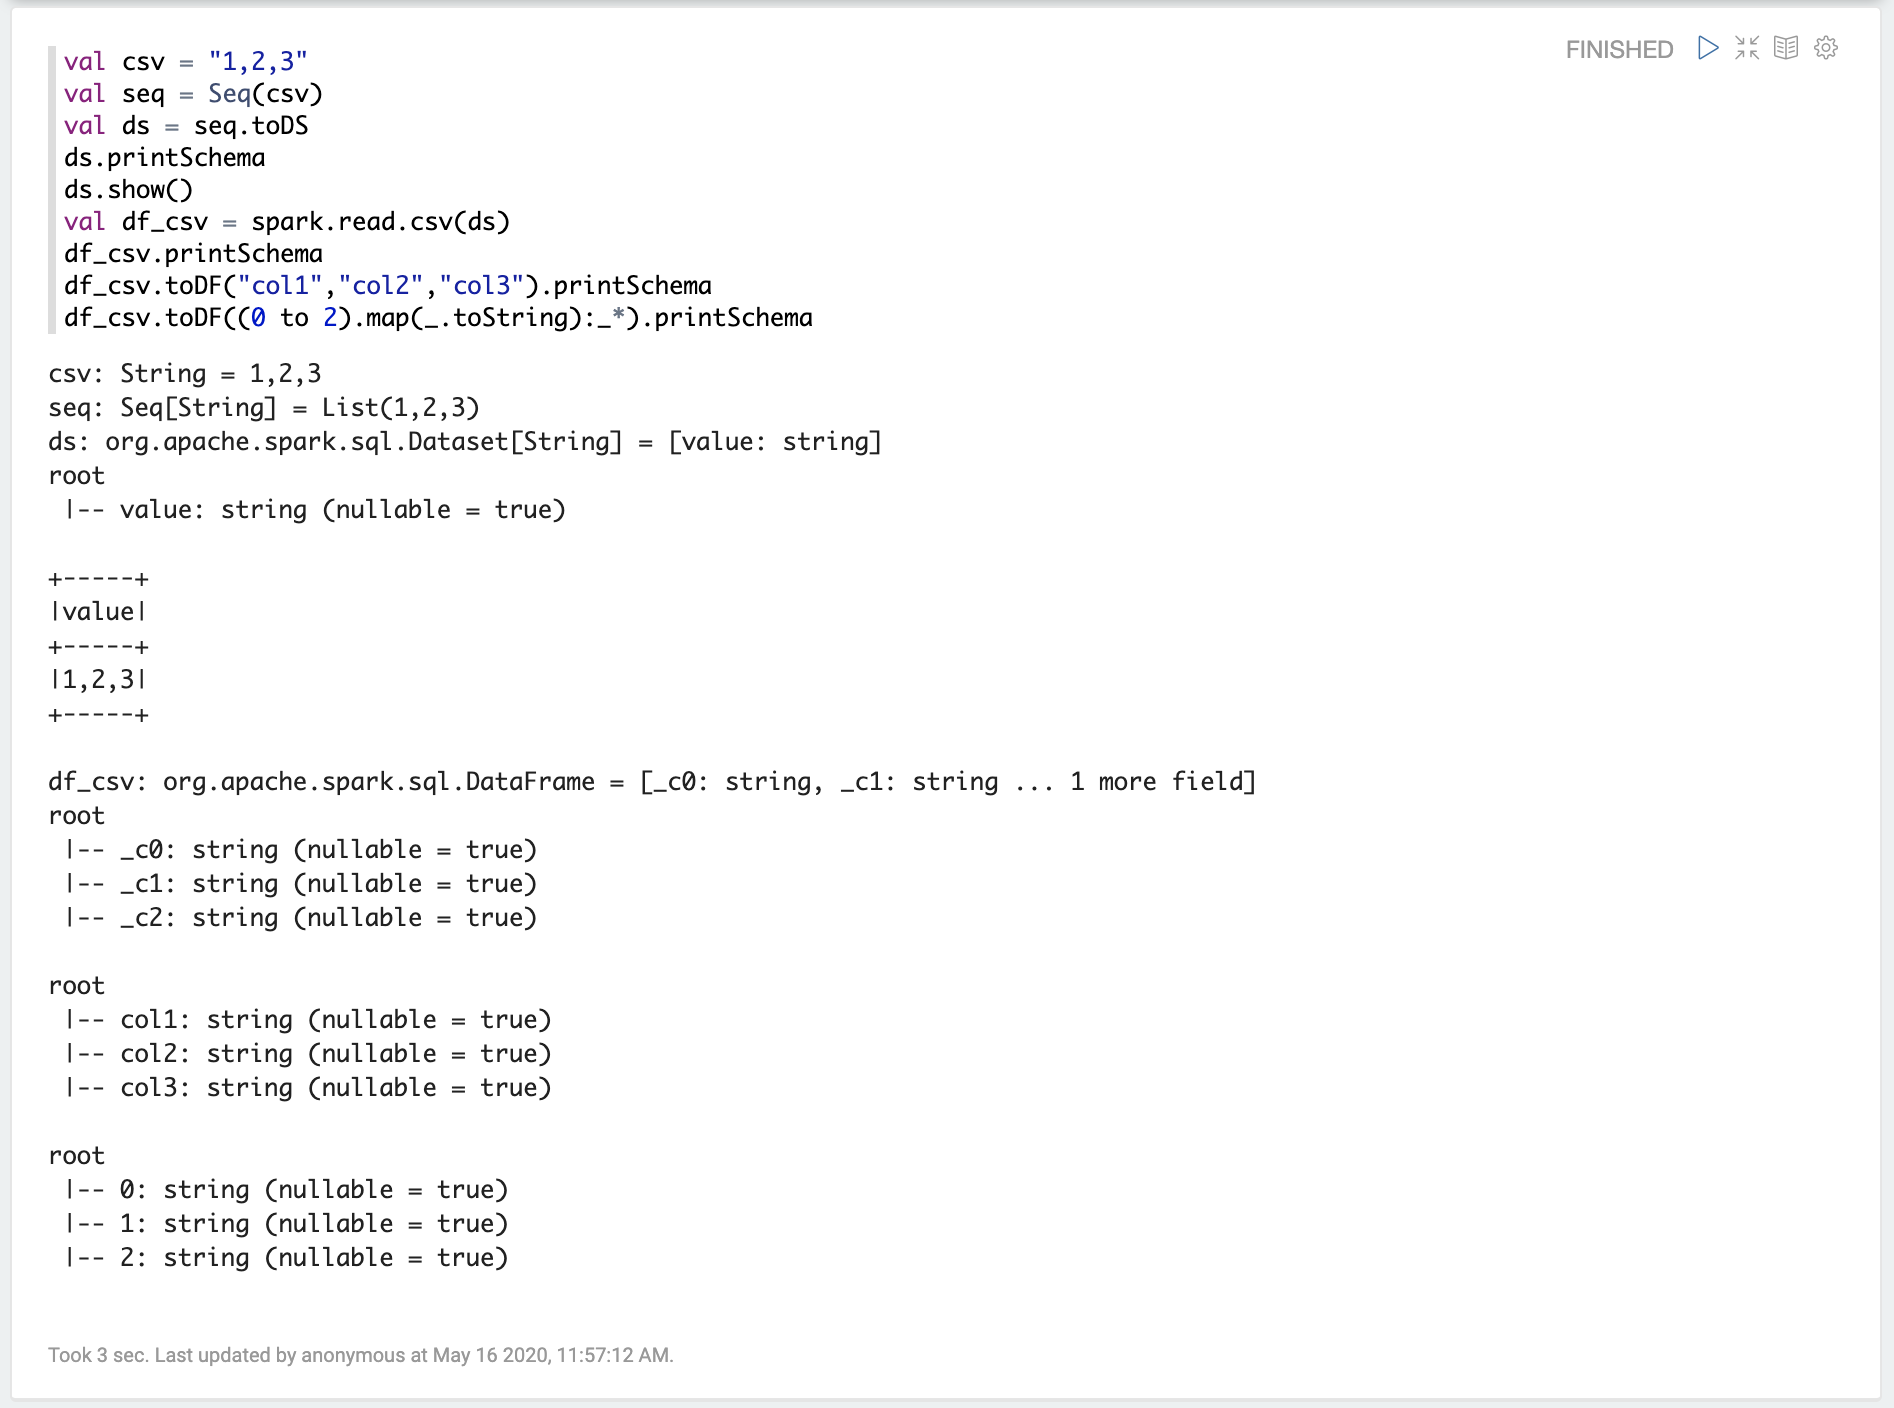

In [28]:
Image('./capture/24_mnist.png')

In [ ]:
val seq = Seq("name, age, address","spark,8,USA")
val ds = seq.toDS
ds.printSchema
ds.show()
val df_csv = spark.read.csv(ds)
df_csv.printSchema
df_csv.show

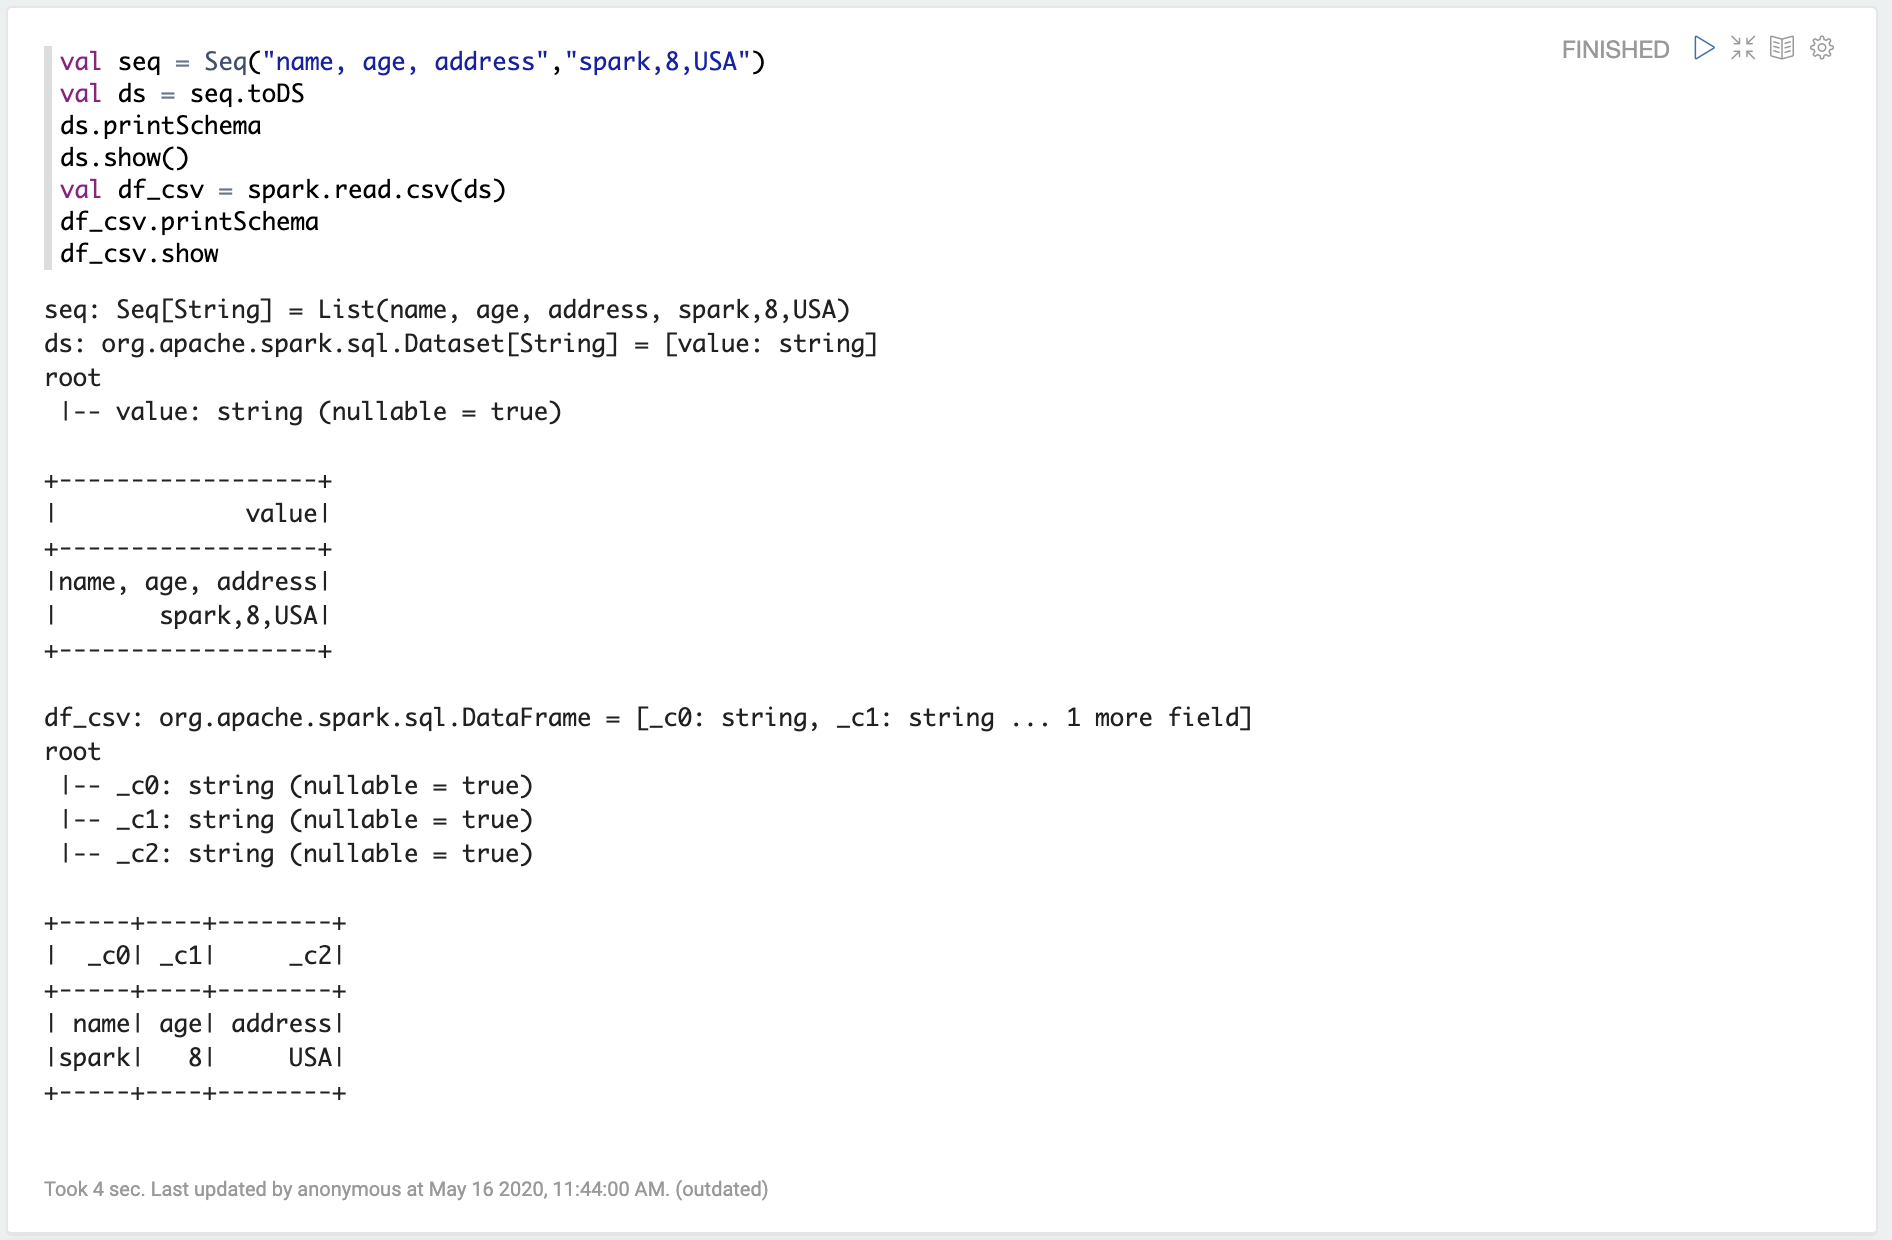

In [25]:
Image('./capture/21_mnist.png')

In [ ]:
val seq = Seq("name, age, address","spark,8,USA")
val ds = seq.toDS
ds.printSchema
ds.show()
val df_csv = spark.read.option("header",true).csv(ds)
df_csv.printSchema
df_csv.show

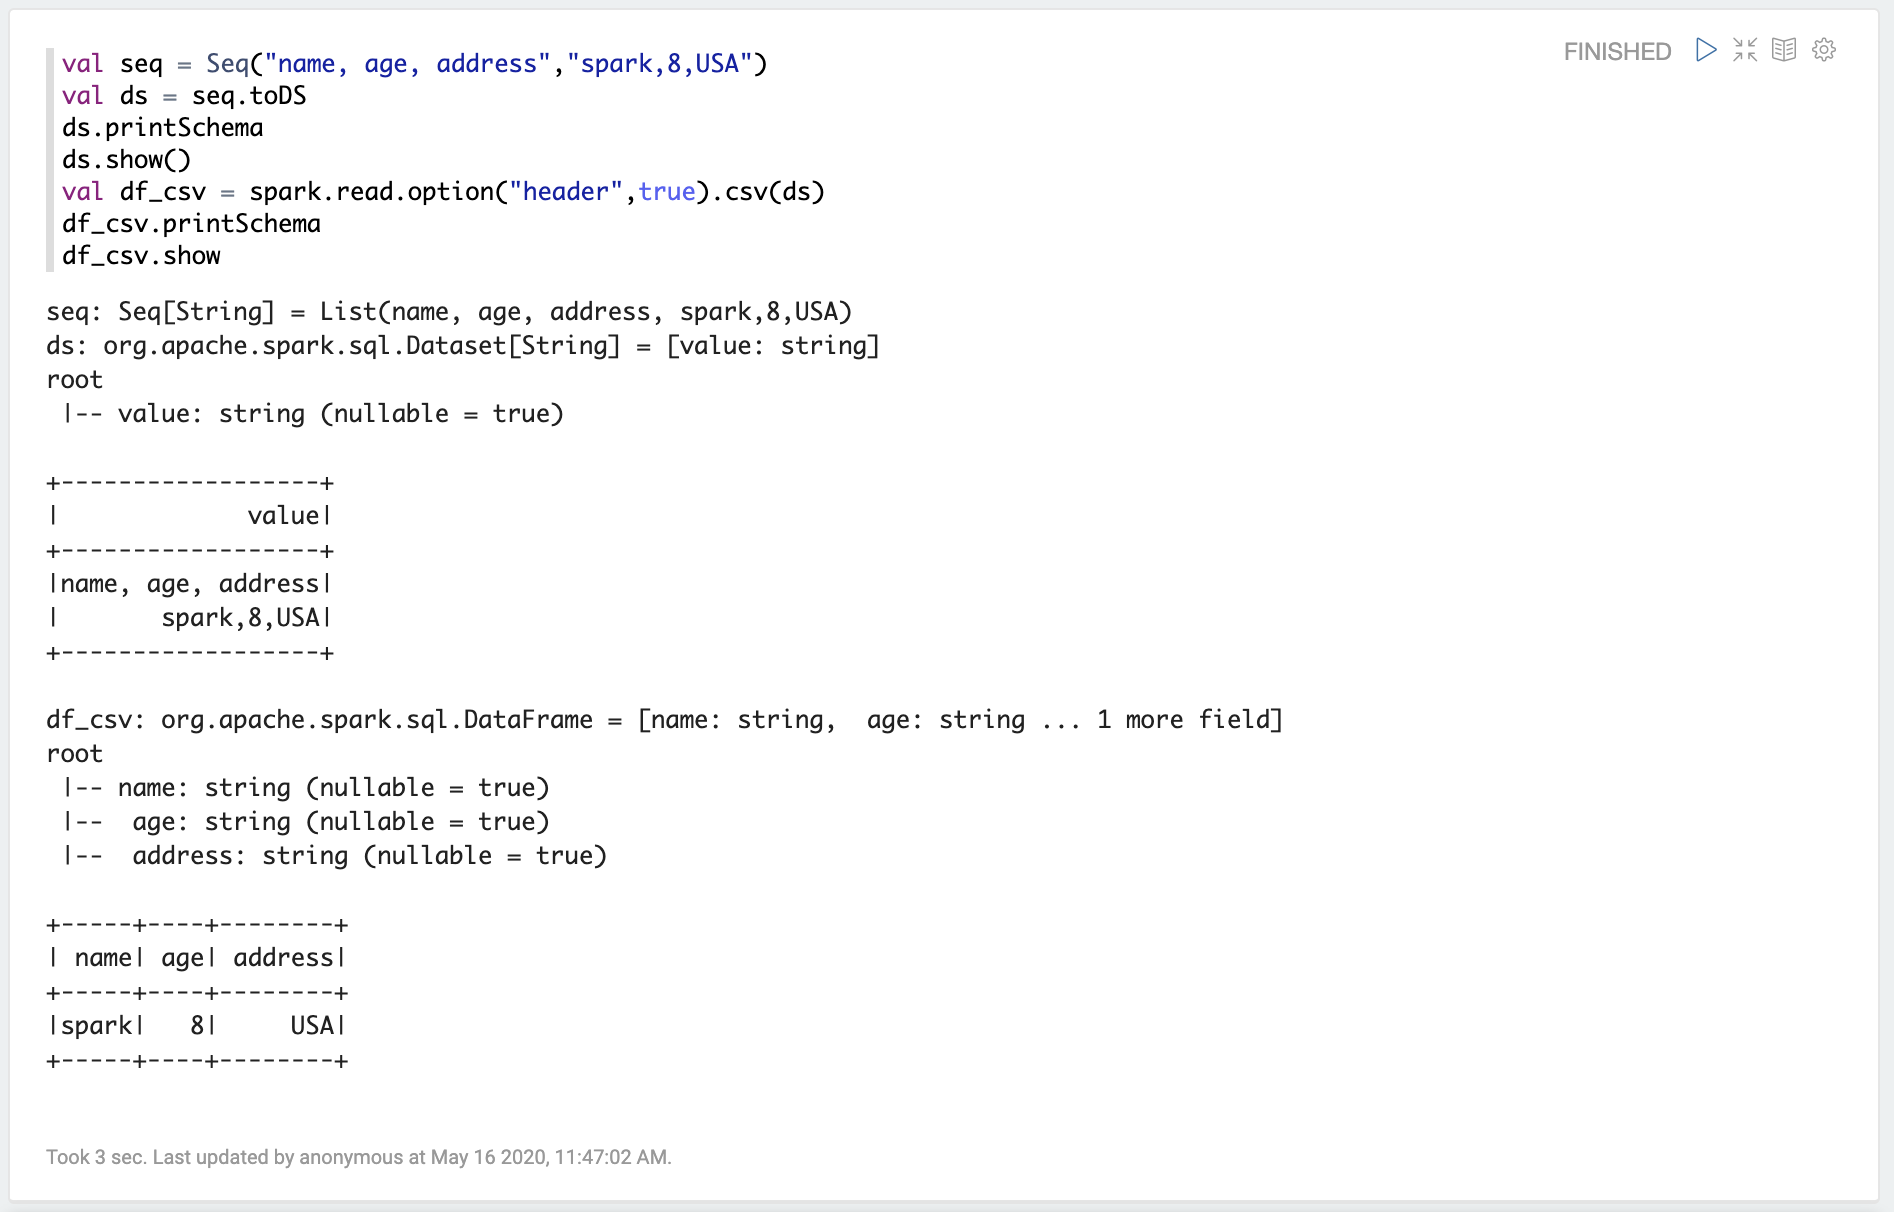

In [26]:
Image('./capture/22_mnist.png')

### test 화면구성 step 02

In [ ]:
#01. angular bind....
z.angularBind("ml_predict_result", "")
z.angularBind("digit_features", "")


#02. load PipelineModel(Transformer)....
import org.apache.spark.ml.{Pipeline,PipelineModel} 
val modelPath= "hdfs://hadoop-master-01:9000/kikang/data/MNIST_mlp2"
val loaded_pipeline_model = PipelineModel.load(s"$modelPath/pipeline-model")


#03. test predict....
val csv = "7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,84,185,159,151,60,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,222,254,254,254,254,241,198,198,198,198,198,198,198,198,170,52,0,0,0,0,0,0,0,0,0,0,0,0,67,114,72,114,163,227,254,225,254,254,254,250,229,254,254,140,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,66,14,67,67,67,59,21,236,254,106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,83,253,209,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,233,255,83,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,129,254,238,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59,249,254,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133,254,187,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,205,248,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,126,254,182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75,251,240,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,221,254,166,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,203,254,219,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,254,254,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,224,254,115,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133,254,254,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,242,254,254,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,254,254,219,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,254,207,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0"

#03.01. define function 'predict'....
import org.apache.spark.sql._
import org.apache.spark.sql.types._


# csv를 Dataframe으로 바꾸는 code
def predict(csv: String, spark: SparkSession, loaded_model: PipelineModel): String = {
    
    println(s">>>> csv: $csv")
    
    #For implicit conversions like converting RDDs to DataFrames
    import spark.implicits._
    
    #Make a Row RDD
    val seq = Seq(csv)
    val rawDS = seq.toDS()
    val rawDF = spark.read.option("inferSchema", true).csv(rawDS)
# rawDF.printSchema()
    
    val seqCols = "label" +: (0 to 783).map("pixel" + _)
    val rawDF2 = rawDF.toDF(seqCols: _*)
    rawDF2.printSchema()
    
    val predict_result = loaded_model.transform(rawDF2)
    predict_result.show(false)
    
    #first : 1st raw , last column(length-1) : correct, get(column index)
    val result = predict_result.first().get(predict_result.columns.length-1)
    println(s">>>> result: $result")
    
    result.toString()
}

#03.02. test predict execution....
val test_result = predict(csv, spark, loaded_pipeline_model)

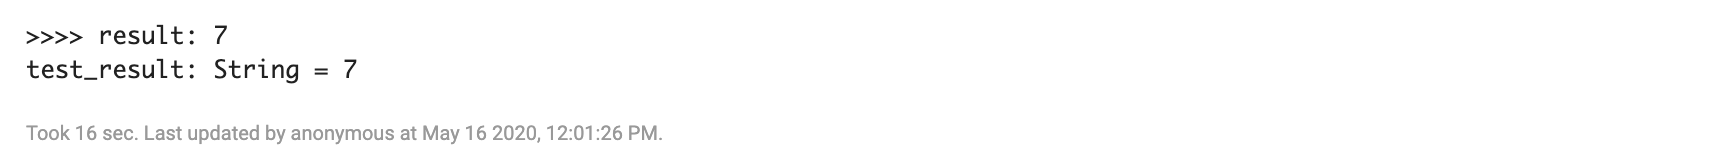

In [29]:
Image('./capture/25_mnist.png')

### 테스트 화면 구성 step 03

In [ ]:
# import org.joda.time.DateTime
# println(new DateTime())
# println(z.angular("digit_features"))

val digit_features = z.angular("digit_features")

if(digit_features.toString.split(",").length == 784) {
#   val digit_features_input = "!!DIGIT_CSV!!" + "9," + z.angular("digit_features")
    val digit_features_input = "9," + z.angular("digit_features")
    val ml_predict_result = predict(digit_features_input, spark, loaded_pipeline_model)
    z.angularBind("ml_predict_result", ml_predict_result)
}

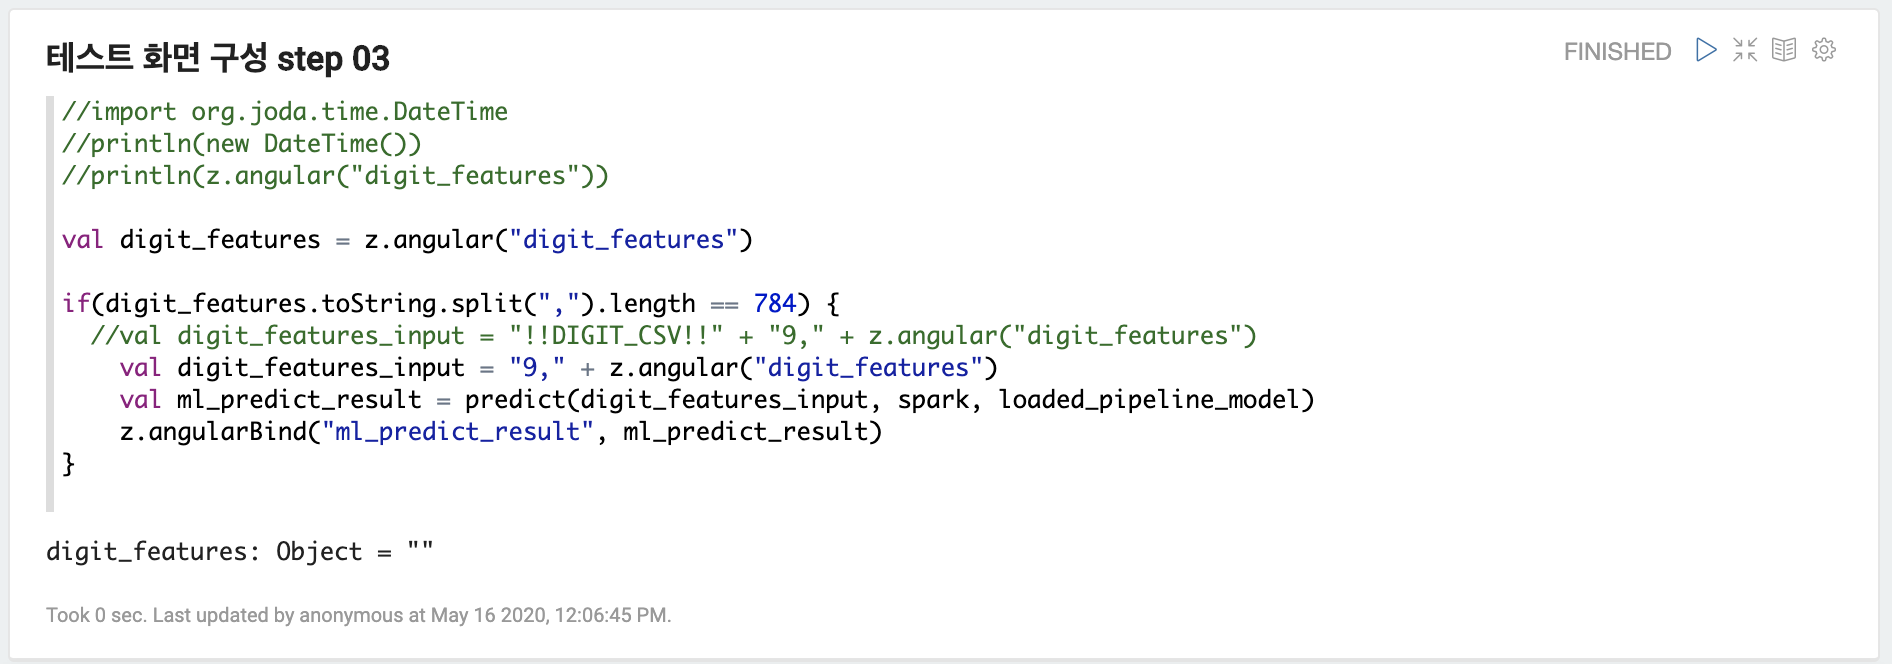

In [30]:
Image('./capture/26_mnist.png')

---- 
#### 다시 

 - step 03 옵션(톱니바퀴)에서 20200516-030110_1747576911 copy
 - Test 화면구성 step 01에 제일 마지막 부분(z.runParagraph) 변경
 - step 03 실행 -> step 01 실행하면 제대로 글자 인식

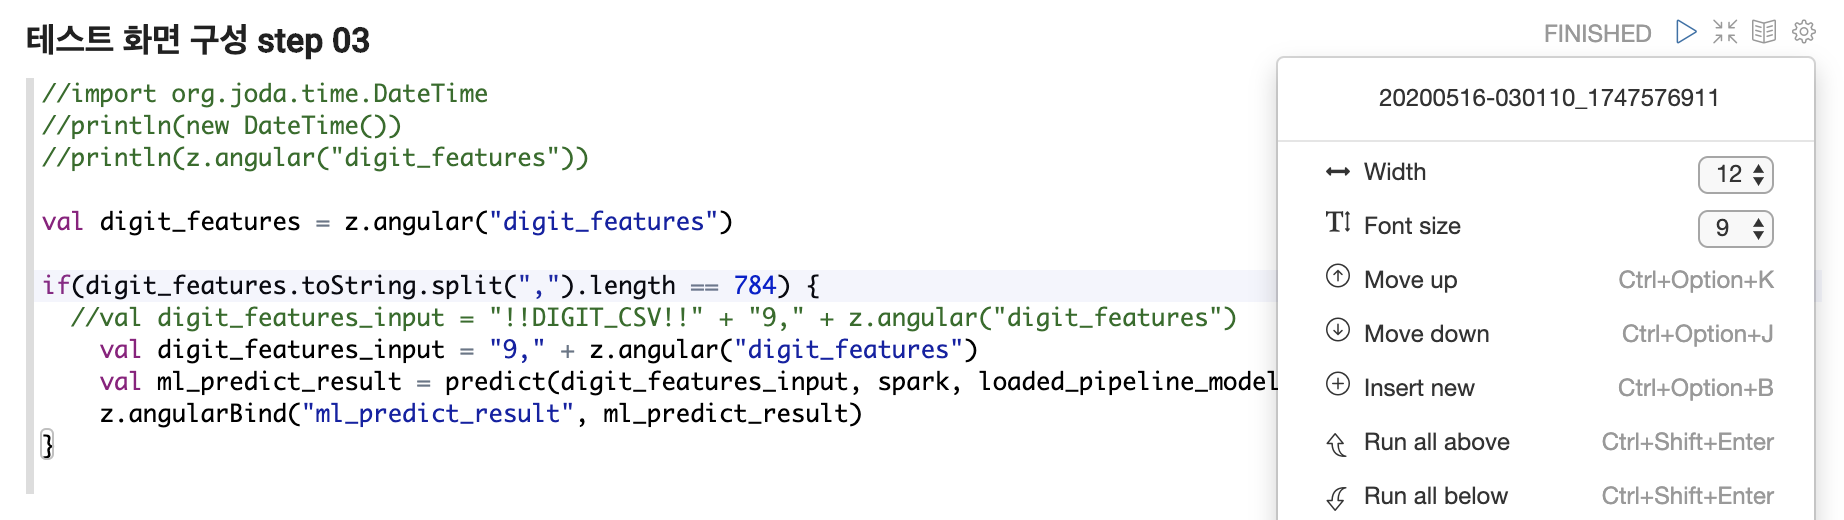

In [31]:
Image('./capture/27_mnist.png')

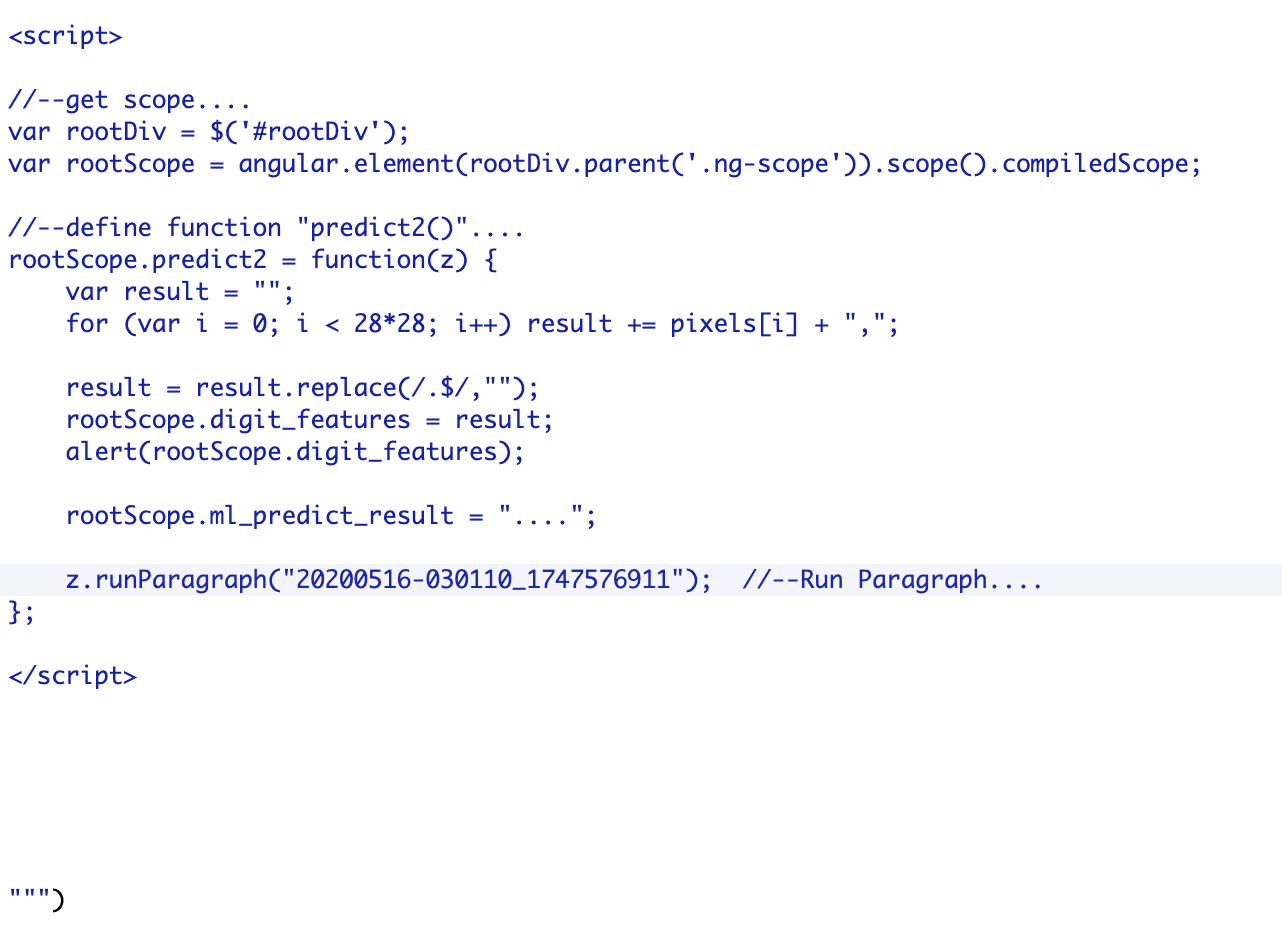

In [32]:
Image('./capture/28_mnist.png')

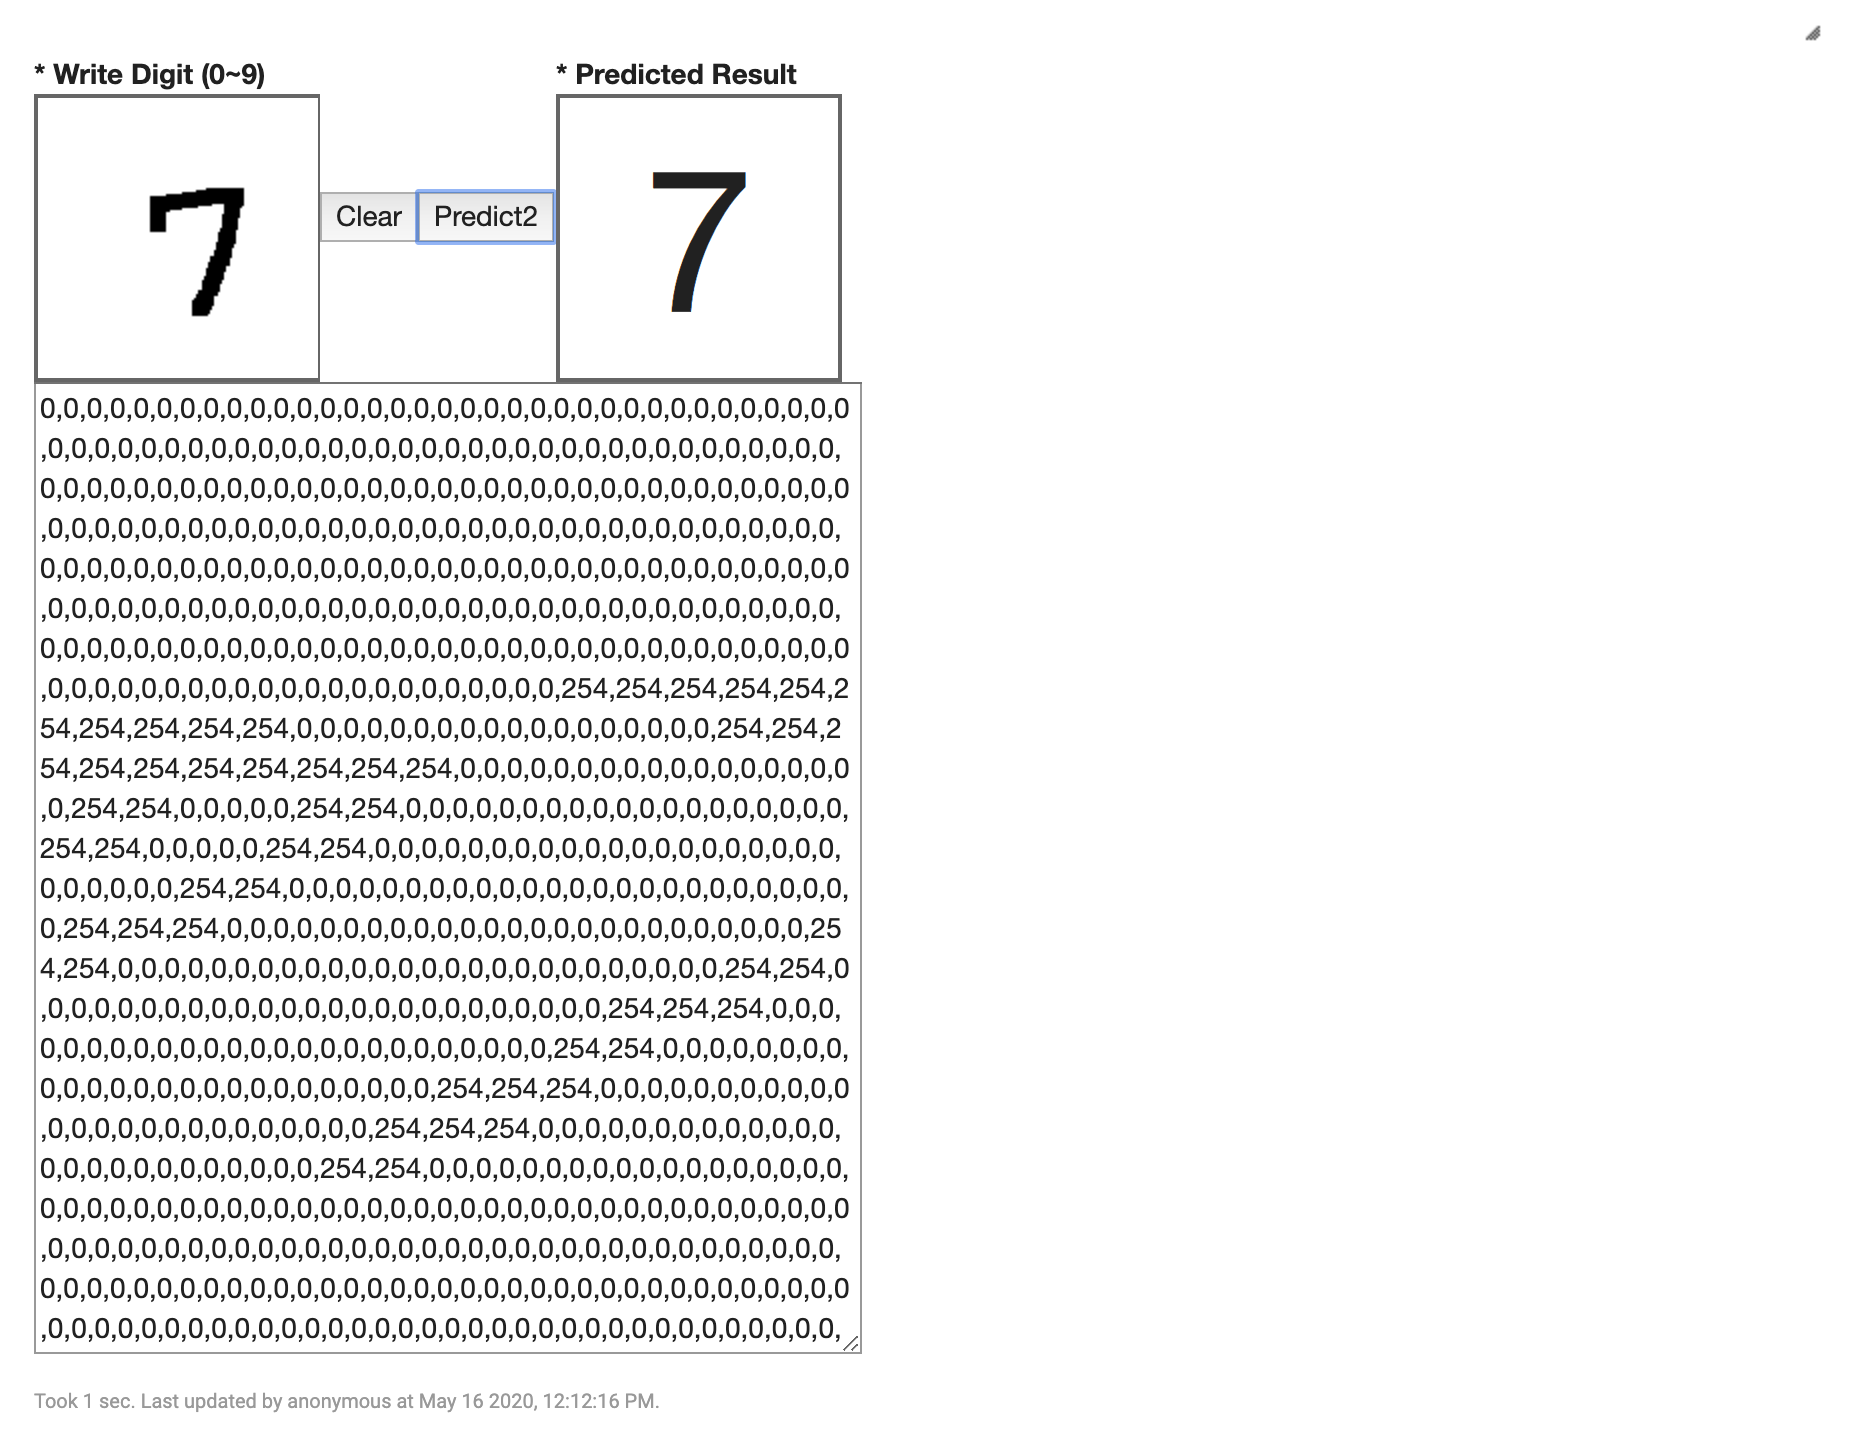

In [33]:
Image('./capture/29_mnist.png')